<a href="https://colab.research.google.com/github/Vamsi-Malineni/work/blob/master/nsf_net_50_mini_batching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io
import time
import pandas as pd
import math
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import copy
from pyDOE import lhs
from tqdm import tqdm

# set random seed
np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

tf.compat.v1.disable_eager_execution()

In [ ]:
class VPNSFnet:
    # Initialize the class
    def __init__(self,domain,initial,boundary,ntrain,batch_size,layers,re,load_model=False,filedr=''):
        
        self.domain   = domain
        self.initial  = initial
        self.boundary = boundary
        
        self.ntrain = ntrain
        self.batch_size= batch_size
        
        self.xa=self.domain[:,0].reshape(self.domain[:,0].shape[0],1)
        self.ya=self.domain[:,1].reshape(self.domain[:,1].shape[0],1)
        self.ta=self.domain[:,2].reshape(self.domain[:,2].shape[0],1)
        
        X = np.concatenate([self.xa,self.ya,self.ta], 1)

        self.lowb = X.min(0) 
        self.upb = X.max(0)
        
        # Calling boundary and initial conditions data as they dont change through the adam iterations
                
        self.x0=initial[:,0].reshape(initial[:, 0].shape[0], 1)
        self.y0=initial[:,1].reshape(initial[:, 1].shape[0], 1)
        self.t0=initial[:,2].reshape(initial[:, 2].shape[0], 1)
        self.u0=initial[:,3].reshape(initial[:, 3].shape[0], 1)
        self.v0=initial[:,4].reshape(initial[:, 4].shape[0], 1)
        
        self.xb=boundary[:,0].reshape(boundary[:, 0].shape[0], 1)
        self.yb=boundary[:,1].reshape(boundary[:, 1].shape[0], 1)
        self.tb=boundary[:,2].reshape(boundary[:, 2].shape[0], 1)
        self.ub=boundary[:,3].reshape(boundary[:, 3].shape[0], 1)
        self.vb=boundary[:,4].reshape(boundary[:, 4].shape[0], 1)
        
        # Calling domain data for initializing the neural network before entering the Adam optimization
        self.layers = layers
        self.re = re

        # Initialize NN
        if load_model ==False:
            self.weights, self.biases = self.initialize_NN(self.layers)
        else:
            self.weights,self.biases = self.load_parameters(filedr,self.layers)
            
        self.learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])

        # tf placeholders and graph
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        # Initial conditions placeholders
        self.x_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.y_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.t_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.u_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        # Boundary conditions placeholders
        self.x_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xb.shape[1]])
        self.y_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.yb.shape[1]])
        self.t_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.tb.shape[1]])
        self.u_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ub.shape[1]])
        self.v_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.vb.shape[1]])
        
        # Domain placeholders having the size of batch_size
        self.x_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xa.shape[1]])
        self.y_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ya.shape[1]])
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ta.shape[1]])

        # Initial conditions predictions
        self.u_ini_pred, self.v_ini_pred, self.p_ini_pred =\
            self.net_NS(self.x_ini_tf, self.y_ini_tf, self.t_ini_tf)
        
        # Boundary conditions predictions
        self.u_boundary_pred, self.v_boundary_pred, self.p_boundary_pred = \
            self.net_NS(self.x_boundary_tf, self.y_boundary_tf, self.t_boundary_tf)
        
        # Domain predictions
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.t_tf)

        alpha, beta = 1, 1

        # set loss function
        self.initial_loss  = alpha * tf.reduce_mean(input_tensor=tf.square(self.u_ini_tf - self.u_ini_pred)) + \
                             alpha * tf.reduce_mean(input_tensor=tf.square(self.v_ini_tf - self.v_ini_pred))
        
        self.boundary_loss = beta * tf.reduce_mean(input_tensor=tf.square(self.u_boundary_tf - self.u_boundary_pred)) + \
                             beta * tf.reduce_mean(input_tensor=tf.square(self.v_boundary_tf - self.v_boundary_pred))

        self.residual_loss = tf.reduce_mean(input_tensor=tf.square(self.f_u_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_v_pred)) + \
                             tf.reduce_mean(input_tensor=tf.square(self.f_e_pred))

        
        self.loss =  self.initial_loss + self.boundary_loss + self.residual_loss
        
        self.loss_i=[]
        self.loss_b=[]
        self.loss_r=[]
                    

        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)
        

#===========================================================================================================#
#====================================Transfer Learning======================================================#
#===========================================================================================================#
    def save_parameters(self,fileDr):
        weights=self.sess.run(self.weights)
        biases= self.sess.run(self.biases)
        
                       
        root_path=Path("E:\Vamsi_oe20s302\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([weights,biases],f)
            print("Parameters are saved in pickle file")

    def load_parameters(self,fileDr,layers):
        tf_weights=[]
        tf_biases=[]
        num_layers=len(layers)
        
        root_path=Path("E:\Vamsi_oe20s302\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            weights,biases=pickle.load(f)
            assert num_layers == (len(weights)+1)
        
        # returns the weights and biases of the network as tf.variable
        for num in range(0,num_layers-1):
            W=tf.Variable(weights[num])
            b=tf.Variable(biases[num])
            tf_weights.append(W)
            tf_biases.append(b)
         
        
        print("Parameters are loaded succesffuly")
        
        return tf_weights,tf_biases
    


# initialize the weight and bias
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# generate the neural network
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

# ###################without assume###############
    # supervised data driven
    def net_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        u_t = tf.gradients(ys=u, xs=t)[0] 
        u_x = tf.gradients(ys=u, xs=x)[0] 
        u_y = tf.gradients(ys=u, xs=y)[0] 
        u_xx = tf.gradients(ys=u_x, xs=x)[0] 
        u_yy = tf.gradients(ys=u_y, xs=y)[0] 
        
        v_t = tf.gradients(ys=v, xs=t)[0] 
        v_x = tf.gradients(ys=v, xs=x)[0] 
        v_y = tf.gradients(ys=v, xs=y)[0] 
        v_xx = tf.gradients(ys=v_x, xs=x)[0] 
        v_yy = tf.gradients(ys=v_y, xs=y)[0] 

        p_x = tf.gradients(ys=p, xs=x)[0] 
        p_y = tf.gradients(ys=p, xs=y)[0] 

        f_u = u_t + (u * u_x + v * u_y) + p_x - (1/self.re) * (u_xx + u_yy)
        f_v = v_t + (u * v_x + v * v_y) + p_y - (1/self.re) * (v_xx + v_yy)
        f_e = u_x + v_y

        return u, v, p, f_u, f_v, f_e


# tf_dict is used to connect model variable and data

    def Adam_train(self, epoch=5000, learning_rate=1e-3):

        start_time = time.time()
        
        iters = int(self.ntrain / self.batch_size)
        
        for it in range(epoch):
            
            for i in (range(iters)):
            
                # Randomly sampling ntrain datapoints in the spatio-temporal region
                idx=np.random.choice(self.domain.shape[0],self.batch_size,replace=False)
                self.data_domain=self.domain[idx,:]
                
                xd=self.data_domain[:,0].reshape(self.data_domain[:, 0].shape[0], 1)
                yd=self.data_domain[:,1].reshape(self.data_domain[:, 1].shape[0], 1)
                td=self.data_domain[:,2].reshape(self.data_domain[:, 2].shape[0], 1)

                tf_dict = {self.x_ini_tf: self.x0, 
                           self.y_ini_tf: self.y0,
                           self.t_ini_tf: self.t0, 
                           self.u_ini_tf: self.u0,
                           self.v_ini_tf: self.v0, 
                           
                           self.x_boundary_tf: self.xb,
                           self.y_boundary_tf: self.yb, 
                           self.t_boundary_tf: self.tb,
                           self.u_boundary_tf: self.ub, 
                           self.v_boundary_tf: self.vb,
                           
                           self.x_tf: xd, 
                           self.y_tf: yd, 
                           self.t_tf: td,
                           
                           self.learning_rate: learning_rate}

                self.sess.run(self.train_op_Adam, tf_dict)
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                # logging the loss values 
                self.loss_i.append(self.sess.run(self.initial_loss,tf_dict))
                self.loss_b.append(self.sess.run(self.boundary_loss,tf_dict))
                self.loss_r.append(self.sess.run(self.residual_loss,tf_dict))

                print('epochs: %d, Loss: %.3e, Time: %.2f' %
                      (it, loss_value, elapsed))
                start_time = time.time()
            if it % 1000 == 0 and it > 0:
                self.save_parameters('params_re50_minibatching')


# 不需要改变 可能需要注意x_tf等

    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star

In [ ]:
def load_data():

    path=r"E:\Vamsi_oe20s302\Research work\Simulations and data\Unsteady trials\data\trials\Re50_data"

    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()
    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()
    press=pd.read_csv(path+r"/press.csv")
    press=press.to_numpy()
    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()
    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()
    t=t-t[0]

    N=xy.shape[0]
    T=t.shape[0]

    XX = np.tile(xy[:,0:1], (1,T)) # N x T
    YY = np.tile(xy[:,1:2], (1,T)) # N x T
    TT = np.tile(t, (1,N)).T # N x T
    x = XX.flatten()[:,None] # NT x 1
    y = YY.flatten()[:,None] # NT x 1
    t = TT.flatten()[:,None] # NT x 1
    u = uvel.flatten()[:,None] # NT x 1
    v = vvel.flatten()[:,None] # NT x 1
    p = press.flatten()[:,None] # NT x 1
    ax=np.unique(x)
    xmin=min(ax)
    xmax=max(ax)
    ay=np.unique(y)
    ymin=min(ay)
    ymax=max(ay)
    at=np.unique(t)
    tmin=min(at)
    tmax=max(at)

    data1=np.concatenate([x ,y ,t , u , v ,p ],1)

    #======================== domain =================================#
    data2=data1[:,:][data1[:,2]<=19.9] # Taking data upto time step 20.0

    data3=data2[:,:][data2[:,0]>=xmin] # Taking data greater than xmin

    data4=data3[:,:][data3[:,0]<=xmax] # Taking data less than xmax

    data5=data4[:,:][data4[:,1]>=ymin] # Taking data greater than ymin

    data_domain=data5[:,:][data5[:,1]<=ymax] # Taking data less than ymax

    #======================== initial =================================#
    data_t0 = data_domain[:, :][data_domain[:, 2] == 0]

    #======================== boundary =================================#
    bc1_data=data_domain[:,:][data_domain[:,1]==ymax]
    bc2_data=data_domain[:,:][data_domain[:,0]==xmin]
    bc3_data=data_domain[:,:][data_domain[:,0]==xmax]
    bc4_data=data_domain[:,:][data_domain[:,1]==ymin]

    data_sup_b_train = np.concatenate([bc2_data,bc3_data,bc4_data,bc1_data], 0)


    return data_domain[:,0:3],data_t0,data_sup_b_train  

In [ ]:
if __name__ == "__main__":
    # when model is directly run this will implement
    # supervised

    N_train = 140000
    batch_size=10000
    Reynolds = 50
    layers = [3]+10*[50]+[3]
    
    domain,initial,boundary=load_data()

    
    with tf.device('/gpu:0'):
        
        model = VPNSFnet(domain,initial,boundary,N_train,batch_size,layers,re=Reynolds,load_model=False,filedr='')

        model.Adam_train(5000, 1e-3)
        model.Adam_train(5000, 1e-4)
        model.Adam_train(50000, 1e-5)
        model.Adam_train(50000, 1e-6)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

epochs: 0, Loss: 3.338e-01, Time: 3.37
epochs: 10, Loss: 1.756e-01, Time: 13.31
epochs: 20, Loss: 8.373e-02, Time: 13.31
epochs: 30, Loss: 6.363e-02, Time: 13.43
epochs: 40, Loss: 5.067e-02, Time: 13.60
epochs: 50, Loss: 4.153e-02, Time: 13.41
epochs: 60, Loss: 4.486e-02, Time: 13.23
epochs: 70, Loss: 3.315e-02, Time: 13.25
epochs: 80, Loss: 3.069e-02, Time: 13.36
epochs: 90, Loss: 2.782e-02, Time: 13.34
epochs: 100, Loss: 3.110e-02, Time: 13.36
epochs: 110, Loss: 2.629e-02, Time: 13.41
epochs: 120, Loss: 2.646e-02, Time: 13.49
epochs: 130, Loss: 2.326e-02, Time: 13.63
epochs: 140, Loss: 2.344e-02, Time: 13.68
epochs: 150, Loss: 2.422e-02, Time: 13.37
epochs: 160, Loss: 2.310e-02, Time: 13.40
e

epochs: 1860, Loss: 6.583e-03, Time: 13.68
epochs: 1870, Loss: 6.589e-03, Time: 13.61
epochs: 1880, Loss: 2.112e-02, Time: 13.73
epochs: 1890, Loss: 6.518e-03, Time: 13.64
epochs: 1900, Loss: 6.450e-03, Time: 13.62
epochs: 1910, Loss: 6.592e-03, Time: 13.68
epochs: 1920, Loss: 6.288e-03, Time: 13.42
epochs: 1930, Loss: 6.577e-03, Time: 13.28
epochs: 1940, Loss: 6.992e-03, Time: 13.30
epochs: 1950, Loss: 1.079e-02, Time: 13.93
epochs: 1960, Loss: 6.634e-03, Time: 13.72
epochs: 1970, Loss: 8.364e-03, Time: 13.61
epochs: 1980, Loss: 6.641e-03, Time: 13.86
epochs: 1990, Loss: 7.051e-03, Time: 13.75
epochs: 2000, Loss: 6.273e-03, Time: 13.72
Parameters are saved in pickle file
epochs: 2010, Loss: 5.787e-03, Time: 13.76
epochs: 2020, Loss: 7.331e-03, Time: 13.73
epochs: 2030, Loss: 6.130e-03, Time: 13.63
epochs: 2040, Loss: 6.083e-03, Time: 13.68
epochs: 2050, Loss: 5.666e-03, Time: 13.80
epochs: 2060, Loss: 6.907e-03, Time: 13.73
epochs: 2070, Loss: 5.444e-03, Time: 13.42
epochs: 2080, Loss

epochs: 3750, Loss: 3.557e-03, Time: 13.50
epochs: 3760, Loss: 3.774e-03, Time: 13.42
epochs: 3770, Loss: 6.919e-03, Time: 13.49
epochs: 3780, Loss: 3.811e-03, Time: 13.42
epochs: 3790, Loss: 3.719e-03, Time: 13.40
epochs: 3800, Loss: 3.531e-03, Time: 13.47
epochs: 3810, Loss: 1.450e-02, Time: 13.51
epochs: 3820, Loss: 6.576e-03, Time: 13.51
epochs: 3830, Loss: 4.210e-03, Time: 13.51
epochs: 3840, Loss: 4.310e-03, Time: 13.57
epochs: 3850, Loss: 3.798e-03, Time: 13.62
epochs: 3860, Loss: 3.645e-03, Time: 13.57
epochs: 3870, Loss: 3.634e-03, Time: 13.52
epochs: 3880, Loss: 3.800e-03, Time: 13.56
epochs: 3890, Loss: 3.868e-03, Time: 13.64
epochs: 3900, Loss: 3.620e-03, Time: 13.57
epochs: 3910, Loss: 4.956e-03, Time: 13.51
epochs: 3920, Loss: 3.533e-03, Time: 13.73
epochs: 3930, Loss: 3.916e-03, Time: 13.42
epochs: 3940, Loss: 3.684e-03, Time: 13.60
epochs: 3950, Loss: 3.927e-03, Time: 13.54
epochs: 3960, Loss: 3.697e-03, Time: 13.74
epochs: 3970, Loss: 3.810e-03, Time: 13.56
epochs: 398

epochs: 670, Loss: 3.265e-03, Time: 13.77
epochs: 680, Loss: 3.274e-03, Time: 13.66
epochs: 690, Loss: 3.270e-03, Time: 13.74
epochs: 700, Loss: 3.270e-03, Time: 13.68
epochs: 710, Loss: 3.261e-03, Time: 13.85
epochs: 720, Loss: 3.269e-03, Time: 13.62
epochs: 730, Loss: 3.262e-03, Time: 13.61
epochs: 740, Loss: 3.272e-03, Time: 13.53
epochs: 750, Loss: 3.270e-03, Time: 13.87
epochs: 760, Loss: 3.275e-03, Time: 13.61
epochs: 770, Loss: 3.267e-03, Time: 13.76
epochs: 780, Loss: 3.265e-03, Time: 13.78
epochs: 790, Loss: 3.266e-03, Time: 13.68
epochs: 800, Loss: 3.267e-03, Time: 13.72
epochs: 810, Loss: 3.256e-03, Time: 13.70
epochs: 820, Loss: 3.272e-03, Time: 13.83
epochs: 830, Loss: 3.267e-03, Time: 13.58
epochs: 840, Loss: 3.262e-03, Time: 13.97
epochs: 850, Loss: 3.262e-03, Time: 14.10
epochs: 860, Loss: 3.256e-03, Time: 14.07
epochs: 870, Loss: 3.256e-03, Time: 14.59
epochs: 880, Loss: 3.271e-03, Time: 14.17
epochs: 890, Loss: 3.262e-03, Time: 14.07
epochs: 900, Loss: 3.260e-03, Time

epochs: 2570, Loss: 3.222e-03, Time: 14.49
epochs: 2580, Loss: 3.221e-03, Time: 14.03
epochs: 2590, Loss: 3.221e-03, Time: 14.17
epochs: 2600, Loss: 3.219e-03, Time: 13.91
epochs: 2610, Loss: 3.234e-03, Time: 14.36
epochs: 2620, Loss: 3.223e-03, Time: 13.98
epochs: 2630, Loss: 3.218e-03, Time: 13.75
epochs: 2640, Loss: 3.221e-03, Time: 14.86
epochs: 2650, Loss: 3.221e-03, Time: 14.47
epochs: 2660, Loss: 3.223e-03, Time: 14.27
epochs: 2670, Loss: 3.222e-03, Time: 14.13
epochs: 2680, Loss: 3.218e-03, Time: 14.49
epochs: 2690, Loss: 3.222e-03, Time: 14.43
epochs: 2700, Loss: 3.216e-03, Time: 14.38
epochs: 2710, Loss: 3.225e-03, Time: 14.47
epochs: 2720, Loss: 3.220e-03, Time: 14.47
epochs: 2730, Loss: 3.229e-03, Time: 14.33
epochs: 2740, Loss: 3.218e-03, Time: 14.32
epochs: 2750, Loss: 3.223e-03, Time: 14.39
epochs: 2760, Loss: 3.218e-03, Time: 14.47
epochs: 2770, Loss: 3.223e-03, Time: 14.45
epochs: 2780, Loss: 3.223e-03, Time: 14.38
epochs: 2790, Loss: 3.215e-03, Time: 14.06
epochs: 280

epochs: 4460, Loss: 3.210e-03, Time: 14.08
epochs: 4470, Loss: 3.243e-03, Time: 14.50
epochs: 4480, Loss: 3.211e-03, Time: 14.55
epochs: 4490, Loss: 3.232e-03, Time: 14.28
epochs: 4500, Loss: 3.201e-03, Time: 14.23
epochs: 4510, Loss: 3.201e-03, Time: 14.46
epochs: 4520, Loss: 3.201e-03, Time: 14.18
epochs: 4530, Loss: 3.216e-03, Time: 13.95
epochs: 4540, Loss: 3.204e-03, Time: 13.79
epochs: 4550, Loss: 3.204e-03, Time: 13.84
epochs: 4560, Loss: 3.209e-03, Time: 13.73
epochs: 4570, Loss: 3.222e-03, Time: 13.96
epochs: 4580, Loss: 3.202e-03, Time: 13.98
epochs: 4590, Loss: 3.203e-03, Time: 14.11
epochs: 4600, Loss: 3.201e-03, Time: 14.31
epochs: 4610, Loss: 3.202e-03, Time: 14.67
epochs: 4620, Loss: 3.204e-03, Time: 14.25
epochs: 4630, Loss: 3.206e-03, Time: 14.15
epochs: 4640, Loss: 3.203e-03, Time: 14.49
epochs: 4650, Loss: 3.206e-03, Time: 14.36
epochs: 4660, Loss: 3.200e-03, Time: 14.43
epochs: 4670, Loss: 3.207e-03, Time: 14.29
epochs: 4680, Loss: 3.203e-03, Time: 14.42
epochs: 469

epochs: 1390, Loss: 3.194e-03, Time: 13.76
epochs: 1400, Loss: 3.194e-03, Time: 13.86
epochs: 1410, Loss: 3.195e-03, Time: 13.82
epochs: 1420, Loss: 3.193e-03, Time: 13.90
epochs: 1430, Loss: 3.192e-03, Time: 13.72
epochs: 1440, Loss: 3.194e-03, Time: 13.96
epochs: 1450, Loss: 3.193e-03, Time: 13.65
epochs: 1460, Loss: 3.194e-03, Time: 13.85
epochs: 1470, Loss: 3.194e-03, Time: 13.81
epochs: 1480, Loss: 3.193e-03, Time: 13.66
epochs: 1490, Loss: 3.193e-03, Time: 13.66
epochs: 1500, Loss: 3.195e-03, Time: 13.83
epochs: 1510, Loss: 3.192e-03, Time: 13.73
epochs: 1520, Loss: 3.198e-03, Time: 13.73
epochs: 1530, Loss: 3.195e-03, Time: 13.88
epochs: 1540, Loss: 3.195e-03, Time: 13.66
epochs: 1550, Loss: 3.194e-03, Time: 13.68
epochs: 1560, Loss: 3.195e-03, Time: 13.72
epochs: 1570, Loss: 3.193e-03, Time: 13.68
epochs: 1580, Loss: 3.193e-03, Time: 13.72
epochs: 1590, Loss: 3.194e-03, Time: 13.70
epochs: 1600, Loss: 3.195e-03, Time: 13.96
epochs: 1610, Loss: 3.195e-03, Time: 13.69
epochs: 162

epochs: 3280, Loss: 3.191e-03, Time: 13.75
epochs: 3290, Loss: 3.192e-03, Time: 13.80
epochs: 3300, Loss: 3.190e-03, Time: 13.74
epochs: 3310, Loss: 3.190e-03, Time: 13.55
epochs: 3320, Loss: 3.191e-03, Time: 13.76
epochs: 3330, Loss: 3.194e-03, Time: 13.77
epochs: 3340, Loss: 3.190e-03, Time: 13.85
epochs: 3350, Loss: 3.192e-03, Time: 13.91
epochs: 3360, Loss: 3.190e-03, Time: 13.82
epochs: 3370, Loss: 3.191e-03, Time: 14.10
epochs: 3380, Loss: 3.190e-03, Time: 13.67
epochs: 3390, Loss: 3.190e-03, Time: 13.77
epochs: 3400, Loss: 3.192e-03, Time: 13.67
epochs: 3410, Loss: 3.190e-03, Time: 13.74
epochs: 3420, Loss: 3.193e-03, Time: 14.02
epochs: 3430, Loss: 3.191e-03, Time: 13.88
epochs: 3440, Loss: 3.192e-03, Time: 13.68
epochs: 3450, Loss: 3.190e-03, Time: 13.91
epochs: 3460, Loss: 3.190e-03, Time: 13.91
epochs: 3470, Loss: 3.191e-03, Time: 13.81
epochs: 3480, Loss: 3.189e-03, Time: 13.81
epochs: 3490, Loss: 3.190e-03, Time: 13.56
epochs: 3500, Loss: 3.191e-03, Time: 13.91
epochs: 351

epochs: 5170, Loss: 3.187e-03, Time: 13.67
epochs: 5180, Loss: 3.189e-03, Time: 13.60
epochs: 5190, Loss: 3.189e-03, Time: 13.66
epochs: 5200, Loss: 3.188e-03, Time: 13.80
epochs: 5210, Loss: 3.188e-03, Time: 13.72
epochs: 5220, Loss: 3.187e-03, Time: 13.84
epochs: 5230, Loss: 3.188e-03, Time: 13.98
epochs: 5240, Loss: 3.188e-03, Time: 13.66
epochs: 5250, Loss: 3.189e-03, Time: 13.70
epochs: 5260, Loss: 3.188e-03, Time: 13.84
epochs: 5270, Loss: 3.187e-03, Time: 13.73
epochs: 5280, Loss: 3.187e-03, Time: 13.60
epochs: 5290, Loss: 3.187e-03, Time: 13.78
epochs: 5300, Loss: 3.187e-03, Time: 13.88
epochs: 5310, Loss: 3.188e-03, Time: 13.72
epochs: 5320, Loss: 3.189e-03, Time: 13.68
epochs: 5330, Loss: 3.188e-03, Time: 13.87
epochs: 5340, Loss: 3.187e-03, Time: 13.68
epochs: 5350, Loss: 3.187e-03, Time: 13.78
epochs: 5360, Loss: 3.189e-03, Time: 13.78
epochs: 5370, Loss: 3.186e-03, Time: 13.75
epochs: 5380, Loss: 3.187e-03, Time: 13.64
epochs: 5390, Loss: 3.189e-03, Time: 13.59
epochs: 540

epochs: 7060, Loss: 3.185e-03, Time: 13.63
epochs: 7070, Loss: 3.186e-03, Time: 13.74
epochs: 7080, Loss: 3.186e-03, Time: 13.73
epochs: 7090, Loss: 3.185e-03, Time: 13.79
epochs: 7100, Loss: 3.186e-03, Time: 13.92
epochs: 7110, Loss: 3.185e-03, Time: 13.74
epochs: 7120, Loss: 3.185e-03, Time: 13.70
epochs: 7130, Loss: 3.186e-03, Time: 13.82
epochs: 7140, Loss: 3.184e-03, Time: 13.79
epochs: 7150, Loss: 3.184e-03, Time: 13.91
epochs: 7160, Loss: 3.184e-03, Time: 13.77
epochs: 7170, Loss: 3.184e-03, Time: 13.79
epochs: 7180, Loss: 3.185e-03, Time: 13.68
epochs: 7190, Loss: 3.184e-03, Time: 13.89
epochs: 7200, Loss: 3.184e-03, Time: 13.82
epochs: 7210, Loss: 3.185e-03, Time: 13.71
epochs: 7220, Loss: 3.185e-03, Time: 13.74
epochs: 7230, Loss: 3.186e-03, Time: 13.72
epochs: 7240, Loss: 3.188e-03, Time: 13.81
epochs: 7250, Loss: 3.186e-03, Time: 13.79
epochs: 7260, Loss: 3.184e-03, Time: 13.76
epochs: 7270, Loss: 3.185e-03, Time: 14.06
epochs: 7280, Loss: 3.184e-03, Time: 13.88
epochs: 729

epochs: 8960, Loss: 3.182e-03, Time: 13.89
epochs: 8970, Loss: 3.183e-03, Time: 13.90
epochs: 8980, Loss: 3.183e-03, Time: 13.88
epochs: 8990, Loss: 3.184e-03, Time: 13.96
epochs: 9000, Loss: 3.181e-03, Time: 13.93
Parameters are saved in pickle file
epochs: 9010, Loss: 3.184e-03, Time: 13.78
epochs: 9020, Loss: 3.183e-03, Time: 13.71
epochs: 9030, Loss: 3.182e-03, Time: 13.78
epochs: 9040, Loss: 3.183e-03, Time: 13.64
epochs: 9050, Loss: 3.184e-03, Time: 13.86
epochs: 9060, Loss: 3.183e-03, Time: 13.71
epochs: 9070, Loss: 3.183e-03, Time: 13.98
epochs: 9080, Loss: 3.181e-03, Time: 13.94
epochs: 9090, Loss: 3.182e-03, Time: 13.85
epochs: 9100, Loss: 3.182e-03, Time: 13.90
epochs: 9110, Loss: 3.184e-03, Time: 13.72
epochs: 9120, Loss: 3.182e-03, Time: 13.59
epochs: 9130, Loss: 3.183e-03, Time: 13.80
epochs: 9140, Loss: 3.182e-03, Time: 13.85
epochs: 9150, Loss: 3.182e-03, Time: 13.82
epochs: 9160, Loss: 3.182e-03, Time: 14.03
epochs: 9170, Loss: 3.182e-03, Time: 13.98
epochs: 9180, Loss

epochs: 10830, Loss: 3.179e-03, Time: 13.87
epochs: 10840, Loss: 3.182e-03, Time: 13.72
epochs: 10850, Loss: 3.181e-03, Time: 13.86
epochs: 10860, Loss: 3.182e-03, Time: 13.82
epochs: 10870, Loss: 3.179e-03, Time: 13.72
epochs: 10880, Loss: 3.180e-03, Time: 13.62
epochs: 10890, Loss: 3.179e-03, Time: 13.83
epochs: 10900, Loss: 3.181e-03, Time: 13.79
epochs: 10910, Loss: 3.178e-03, Time: 13.74
epochs: 10920, Loss: 3.181e-03, Time: 13.78
epochs: 10930, Loss: 3.180e-03, Time: 14.03
epochs: 10940, Loss: 3.180e-03, Time: 13.99
epochs: 10950, Loss: 3.180e-03, Time: 13.85
epochs: 10960, Loss: 3.180e-03, Time: 13.80
epochs: 10970, Loss: 3.181e-03, Time: 13.70
epochs: 10980, Loss: 3.179e-03, Time: 13.63
epochs: 10990, Loss: 3.180e-03, Time: 13.66
epochs: 11000, Loss: 3.180e-03, Time: 13.63
Parameters are saved in pickle file
epochs: 11010, Loss: 3.180e-03, Time: 13.80
epochs: 11020, Loss: 3.181e-03, Time: 13.63
epochs: 11030, Loss: 3.182e-03, Time: 13.71
epochs: 11040, Loss: 3.180e-03, Time: 13

epochs: 12680, Loss: 3.179e-03, Time: 14.05
epochs: 12690, Loss: 3.179e-03, Time: 13.82
epochs: 12700, Loss: 3.179e-03, Time: 13.85
epochs: 12710, Loss: 3.178e-03, Time: 13.85
epochs: 12720, Loss: 3.179e-03, Time: 14.17
epochs: 12730, Loss: 3.179e-03, Time: 13.85
epochs: 12740, Loss: 3.179e-03, Time: 13.79
epochs: 12750, Loss: 3.178e-03, Time: 13.84
epochs: 12760, Loss: 3.178e-03, Time: 13.80
epochs: 12770, Loss: 3.180e-03, Time: 13.82
epochs: 12780, Loss: 3.180e-03, Time: 13.69
epochs: 12790, Loss: 3.178e-03, Time: 13.86
epochs: 12800, Loss: 3.179e-03, Time: 13.75
epochs: 12810, Loss: 3.177e-03, Time: 13.65
epochs: 12820, Loss: 3.179e-03, Time: 13.82
epochs: 12830, Loss: 3.178e-03, Time: 13.98
epochs: 12840, Loss: 3.177e-03, Time: 13.77
epochs: 12850, Loss: 3.178e-03, Time: 13.96
epochs: 12860, Loss: 3.178e-03, Time: 14.01
epochs: 12870, Loss: 3.178e-03, Time: 13.87
epochs: 12880, Loss: 3.179e-03, Time: 13.75
epochs: 12890, Loss: 3.178e-03, Time: 13.81
epochs: 12900, Loss: 3.178e-03, 

epochs: 14530, Loss: 3.176e-03, Time: 13.86
epochs: 14540, Loss: 3.176e-03, Time: 13.83
epochs: 14550, Loss: 3.176e-03, Time: 13.92
epochs: 14560, Loss: 3.177e-03, Time: 13.80
epochs: 14570, Loss: 3.176e-03, Time: 13.84
epochs: 14580, Loss: 3.176e-03, Time: 14.04
epochs: 14590, Loss: 3.175e-03, Time: 13.73
epochs: 14600, Loss: 3.175e-03, Time: 13.75
epochs: 14610, Loss: 3.177e-03, Time: 13.88
epochs: 14620, Loss: 3.176e-03, Time: 13.73
epochs: 14630, Loss: 3.176e-03, Time: 13.77
epochs: 14640, Loss: 3.176e-03, Time: 13.86
epochs: 14650, Loss: 3.175e-03, Time: 13.89
epochs: 14660, Loss: 3.175e-03, Time: 13.83
epochs: 14670, Loss: 3.178e-03, Time: 13.80
epochs: 14680, Loss: 3.177e-03, Time: 14.02
epochs: 14690, Loss: 3.177e-03, Time: 13.67
epochs: 14700, Loss: 3.177e-03, Time: 13.70
epochs: 14710, Loss: 3.176e-03, Time: 13.65
epochs: 14720, Loss: 3.175e-03, Time: 13.86
epochs: 14730, Loss: 3.176e-03, Time: 13.77
epochs: 14740, Loss: 3.175e-03, Time: 13.73
epochs: 14750, Loss: 3.176e-03, 

epochs: 16380, Loss: 3.175e-03, Time: 13.77
epochs: 16390, Loss: 3.175e-03, Time: 13.82
epochs: 16400, Loss: 3.175e-03, Time: 13.75
epochs: 16410, Loss: 3.175e-03, Time: 14.05
epochs: 16420, Loss: 3.174e-03, Time: 14.04
epochs: 16430, Loss: 3.173e-03, Time: 13.82
epochs: 16440, Loss: 3.173e-03, Time: 13.90
epochs: 16450, Loss: 3.175e-03, Time: 13.97
epochs: 16460, Loss: 3.176e-03, Time: 13.86
epochs: 16470, Loss: 3.175e-03, Time: 13.75
epochs: 16480, Loss: 3.174e-03, Time: 13.68
epochs: 16490, Loss: 3.174e-03, Time: 13.82
epochs: 16500, Loss: 3.174e-03, Time: 13.86
epochs: 16510, Loss: 3.174e-03, Time: 14.02
epochs: 16520, Loss: 3.175e-03, Time: 13.94
epochs: 16530, Loss: 3.174e-03, Time: 13.82
epochs: 16540, Loss: 3.174e-03, Time: 13.85
epochs: 16550, Loss: 3.174e-03, Time: 13.86
epochs: 16560, Loss: 3.175e-03, Time: 13.70
epochs: 16570, Loss: 3.174e-03, Time: 13.80
epochs: 16580, Loss: 3.174e-03, Time: 13.88
epochs: 16590, Loss: 3.173e-03, Time: 13.74
epochs: 16600, Loss: 3.174e-03, 

epochs: 18230, Loss: 3.171e-03, Time: 13.64
epochs: 18240, Loss: 3.172e-03, Time: 13.86
epochs: 18250, Loss: 3.173e-03, Time: 13.81
epochs: 18260, Loss: 3.172e-03, Time: 13.86
epochs: 18270, Loss: 3.173e-03, Time: 13.83
epochs: 18280, Loss: 3.173e-03, Time: 13.73
epochs: 18290, Loss: 3.173e-03, Time: 13.75
epochs: 18300, Loss: 3.173e-03, Time: 13.85
epochs: 18310, Loss: 3.174e-03, Time: 13.77
epochs: 18320, Loss: 3.174e-03, Time: 13.74
epochs: 18330, Loss: 3.172e-03, Time: 13.82
epochs: 18340, Loss: 3.172e-03, Time: 13.92
epochs: 18350, Loss: 3.172e-03, Time: 13.79
epochs: 18360, Loss: 3.172e-03, Time: 13.90
epochs: 18370, Loss: 3.174e-03, Time: 13.87
epochs: 18380, Loss: 3.173e-03, Time: 13.80
epochs: 18390, Loss: 3.174e-03, Time: 13.86
epochs: 18400, Loss: 3.172e-03, Time: 13.69
epochs: 18410, Loss: 3.172e-03, Time: 13.81
epochs: 18420, Loss: 3.173e-03, Time: 13.72
epochs: 18430, Loss: 3.173e-03, Time: 13.70
epochs: 18440, Loss: 3.172e-03, Time: 13.87
epochs: 18450, Loss: 3.172e-03, 

epochs: 20080, Loss: 3.171e-03, Time: 13.63
epochs: 20090, Loss: 3.171e-03, Time: 13.98
epochs: 20100, Loss: 3.172e-03, Time: 13.81
epochs: 20110, Loss: 3.172e-03, Time: 13.80
epochs: 20120, Loss: 3.170e-03, Time: 13.84
epochs: 20130, Loss: 3.172e-03, Time: 13.93
epochs: 20140, Loss: 3.170e-03, Time: 13.89
epochs: 20150, Loss: 3.171e-03, Time: 13.88
epochs: 20160, Loss: 3.170e-03, Time: 13.80
epochs: 20170, Loss: 3.170e-03, Time: 13.91
epochs: 20180, Loss: 3.171e-03, Time: 14.11
epochs: 20190, Loss: 3.172e-03, Time: 13.85
epochs: 20200, Loss: 3.169e-03, Time: 13.71
epochs: 20210, Loss: 3.172e-03, Time: 13.93
epochs: 20220, Loss: 3.171e-03, Time: 13.95
epochs: 20230, Loss: 3.170e-03, Time: 13.95
epochs: 20240, Loss: 3.171e-03, Time: 13.76
epochs: 20250, Loss: 3.171e-03, Time: 13.77
epochs: 20260, Loss: 3.170e-03, Time: 13.69
epochs: 20270, Loss: 3.171e-03, Time: 13.83
epochs: 20280, Loss: 3.171e-03, Time: 13.68
epochs: 20290, Loss: 3.170e-03, Time: 13.96
epochs: 20300, Loss: 3.170e-03, 

epochs: 21940, Loss: 3.170e-03, Time: 13.73
epochs: 21950, Loss: 3.170e-03, Time: 13.73
epochs: 21960, Loss: 3.170e-03, Time: 13.89
epochs: 21970, Loss: 3.170e-03, Time: 13.67
epochs: 21980, Loss: 3.169e-03, Time: 13.75
epochs: 21990, Loss: 3.170e-03, Time: 13.79
epochs: 22000, Loss: 3.169e-03, Time: 13.87
Parameters are saved in pickle file
epochs: 22010, Loss: 3.171e-03, Time: 13.90
epochs: 22020, Loss: 3.170e-03, Time: 13.79
epochs: 22030, Loss: 3.170e-03, Time: 14.04
epochs: 22040, Loss: 3.169e-03, Time: 13.94
epochs: 22050, Loss: 3.170e-03, Time: 13.77
epochs: 22060, Loss: 3.170e-03, Time: 13.76
epochs: 22070, Loss: 3.169e-03, Time: 13.84
epochs: 22080, Loss: 3.170e-03, Time: 13.89
epochs: 22090, Loss: 3.170e-03, Time: 13.92
epochs: 22100, Loss: 3.169e-03, Time: 13.98
epochs: 22110, Loss: 3.169e-03, Time: 14.06
epochs: 22120, Loss: 3.169e-03, Time: 14.01
epochs: 22130, Loss: 3.169e-03, Time: 13.88
epochs: 22140, Loss: 3.169e-03, Time: 13.61
epochs: 22150, Loss: 3.170e-03, Time: 13

epochs: 23790, Loss: 3.168e-03, Time: 13.72
epochs: 23800, Loss: 3.170e-03, Time: 13.71
epochs: 23810, Loss: 3.167e-03, Time: 13.73
epochs: 23820, Loss: 3.169e-03, Time: 13.71
epochs: 23830, Loss: 3.169e-03, Time: 13.82
epochs: 23840, Loss: 3.169e-03, Time: 14.04
epochs: 23850, Loss: 3.168e-03, Time: 14.10
epochs: 23860, Loss: 3.168e-03, Time: 13.93
epochs: 23870, Loss: 3.169e-03, Time: 13.88
epochs: 23880, Loss: 3.169e-03, Time: 13.89
epochs: 23890, Loss: 3.168e-03, Time: 13.82
epochs: 23900, Loss: 3.169e-03, Time: 13.81
epochs: 23910, Loss: 3.167e-03, Time: 13.87
epochs: 23920, Loss: 3.169e-03, Time: 13.95
epochs: 23930, Loss: 3.168e-03, Time: 14.13
epochs: 23940, Loss: 3.167e-03, Time: 13.75
epochs: 23950, Loss: 3.168e-03, Time: 13.79
epochs: 23960, Loss: 3.168e-03, Time: 13.65
epochs: 23970, Loss: 3.167e-03, Time: 14.01
epochs: 23980, Loss: 3.168e-03, Time: 13.80
epochs: 23990, Loss: 3.168e-03, Time: 13.72
epochs: 24000, Loss: 3.168e-03, Time: 13.58
Parameters are saved in pickle f

epochs: 25640, Loss: 3.166e-03, Time: 13.81
epochs: 25650, Loss: 3.167e-03, Time: 13.72
epochs: 25660, Loss: 3.167e-03, Time: 13.79
epochs: 25670, Loss: 3.166e-03, Time: 13.93
epochs: 25680, Loss: 3.166e-03, Time: 13.83
epochs: 25690, Loss: 3.167e-03, Time: 13.96
epochs: 25700, Loss: 3.167e-03, Time: 13.76
epochs: 25710, Loss: 3.165e-03, Time: 13.78
epochs: 25720, Loss: 3.167e-03, Time: 13.79
epochs: 25730, Loss: 3.167e-03, Time: 13.60
epochs: 25740, Loss: 3.167e-03, Time: 13.73
epochs: 25750, Loss: 3.167e-03, Time: 13.85
epochs: 25760, Loss: 3.166e-03, Time: 13.74
epochs: 25770, Loss: 3.166e-03, Time: 13.79
epochs: 25780, Loss: 3.167e-03, Time: 14.13
epochs: 25790, Loss: 3.166e-03, Time: 14.03
epochs: 25800, Loss: 3.167e-03, Time: 13.69
epochs: 25810, Loss: 3.168e-03, Time: 14.02
epochs: 25820, Loss: 3.166e-03, Time: 14.12
epochs: 25830, Loss: 3.168e-03, Time: 13.80
epochs: 25840, Loss: 3.167e-03, Time: 13.95
epochs: 25850, Loss: 3.166e-03, Time: 13.76
epochs: 25860, Loss: 3.167e-03, 

epochs: 27490, Loss: 3.166e-03, Time: 13.64
epochs: 27500, Loss: 3.164e-03, Time: 13.63
epochs: 27510, Loss: 3.166e-03, Time: 13.80
epochs: 27520, Loss: 3.166e-03, Time: 13.83
epochs: 27530, Loss: 3.165e-03, Time: 13.95
epochs: 27540, Loss: 3.165e-03, Time: 13.62
epochs: 27550, Loss: 3.165e-03, Time: 13.86
epochs: 27560, Loss: 3.164e-03, Time: 13.66
epochs: 27570, Loss: 3.165e-03, Time: 13.72
epochs: 27580, Loss: 3.166e-03, Time: 13.78
epochs: 27590, Loss: 3.166e-03, Time: 13.74
epochs: 27600, Loss: 3.164e-03, Time: 13.58
epochs: 27610, Loss: 3.165e-03, Time: 13.93
epochs: 27620, Loss: 3.166e-03, Time: 14.03
epochs: 27630, Loss: 3.165e-03, Time: 13.78
epochs: 27640, Loss: 3.166e-03, Time: 13.84
epochs: 27650, Loss: 3.166e-03, Time: 13.81
epochs: 27660, Loss: 3.166e-03, Time: 13.84
epochs: 27670, Loss: 3.165e-03, Time: 13.80
epochs: 27680, Loss: 3.165e-03, Time: 13.90
epochs: 27690, Loss: 3.165e-03, Time: 13.84
epochs: 27700, Loss: 3.164e-03, Time: 13.65
epochs: 27710, Loss: 3.166e-03, 

epochs: 29340, Loss: 3.164e-03, Time: 13.61
epochs: 29350, Loss: 3.165e-03, Time: 13.57
epochs: 29360, Loss: 3.164e-03, Time: 13.69
epochs: 29370, Loss: 3.163e-03, Time: 13.54
epochs: 29380, Loss: 3.164e-03, Time: 13.61
epochs: 29390, Loss: 3.164e-03, Time: 13.52
epochs: 29400, Loss: 3.166e-03, Time: 13.53
epochs: 29410, Loss: 3.165e-03, Time: 13.70
epochs: 29420, Loss: 3.164e-03, Time: 13.92
epochs: 29430, Loss: 3.165e-03, Time: 13.65
epochs: 29440, Loss: 3.163e-03, Time: 13.71
epochs: 29450, Loss: 3.162e-03, Time: 13.88
epochs: 29460, Loss: 3.164e-03, Time: 13.66
epochs: 29470, Loss: 3.164e-03, Time: 13.89
epochs: 29480, Loss: 3.164e-03, Time: 13.62
epochs: 29490, Loss: 3.163e-03, Time: 13.82
epochs: 29500, Loss: 3.164e-03, Time: 13.70
epochs: 29510, Loss: 3.165e-03, Time: 13.69
epochs: 29520, Loss: 3.164e-03, Time: 13.62
epochs: 29530, Loss: 3.165e-03, Time: 13.54
epochs: 29540, Loss: 3.163e-03, Time: 13.49
epochs: 29550, Loss: 3.165e-03, Time: 13.73
epochs: 29560, Loss: 3.165e-03, 

epochs: 31190, Loss: 3.163e-03, Time: 13.87
epochs: 31200, Loss: 3.163e-03, Time: 13.86
epochs: 31210, Loss: 3.163e-03, Time: 13.92
epochs: 31220, Loss: 3.162e-03, Time: 13.65
epochs: 31230, Loss: 3.164e-03, Time: 13.86
epochs: 31240, Loss: 3.163e-03, Time: 13.90
epochs: 31250, Loss: 3.162e-03, Time: 13.79
epochs: 31260, Loss: 3.162e-03, Time: 13.61
epochs: 31270, Loss: 3.162e-03, Time: 13.63
epochs: 31280, Loss: 3.164e-03, Time: 13.54
epochs: 31290, Loss: 3.163e-03, Time: 13.84
epochs: 31300, Loss: 3.163e-03, Time: 13.71
epochs: 31310, Loss: 3.162e-03, Time: 13.72
epochs: 31320, Loss: 3.162e-03, Time: 13.73
epochs: 31330, Loss: 3.163e-03, Time: 13.93
epochs: 31340, Loss: 3.163e-03, Time: 13.67
epochs: 31350, Loss: 3.163e-03, Time: 14.08
epochs: 31360, Loss: 3.162e-03, Time: 13.89
epochs: 31370, Loss: 3.163e-03, Time: 13.83
epochs: 31380, Loss: 3.163e-03, Time: 14.06
epochs: 31390, Loss: 3.163e-03, Time: 14.01
epochs: 31400, Loss: 3.162e-03, Time: 13.94
epochs: 31410, Loss: 3.164e-03, 

epochs: 33040, Loss: 3.162e-03, Time: 13.77
epochs: 33050, Loss: 3.162e-03, Time: 13.97
epochs: 33060, Loss: 3.161e-03, Time: 13.85
epochs: 33070, Loss: 3.161e-03, Time: 13.80
epochs: 33080, Loss: 3.161e-03, Time: 13.85
epochs: 33090, Loss: 3.162e-03, Time: 13.73
epochs: 33100, Loss: 3.160e-03, Time: 13.83
epochs: 33110, Loss: 3.162e-03, Time: 13.82
epochs: 33120, Loss: 3.162e-03, Time: 13.79
epochs: 33130, Loss: 3.161e-03, Time: 13.80
epochs: 33140, Loss: 3.161e-03, Time: 13.82
epochs: 33150, Loss: 3.161e-03, Time: 13.77
epochs: 33160, Loss: 3.161e-03, Time: 13.61
epochs: 33170, Loss: 3.161e-03, Time: 13.75
epochs: 33180, Loss: 3.162e-03, Time: 13.79
epochs: 33190, Loss: 3.162e-03, Time: 13.90
epochs: 33200, Loss: 3.161e-03, Time: 13.90
epochs: 33210, Loss: 3.163e-03, Time: 13.66
epochs: 33220, Loss: 3.162e-03, Time: 13.71
epochs: 33230, Loss: 3.161e-03, Time: 13.82
epochs: 33240, Loss: 3.161e-03, Time: 13.76
epochs: 33250, Loss: 3.161e-03, Time: 14.14
epochs: 33260, Loss: 3.161e-03, 

epochs: 34900, Loss: 3.160e-03, Time: 13.58
epochs: 34910, Loss: 3.161e-03, Time: 13.81
epochs: 34920, Loss: 3.160e-03, Time: 13.71
epochs: 34930, Loss: 3.160e-03, Time: 13.56
epochs: 34940, Loss: 3.160e-03, Time: 13.75
epochs: 34950, Loss: 3.160e-03, Time: 13.73
epochs: 34960, Loss: 3.162e-03, Time: 13.91
epochs: 34970, Loss: 3.160e-03, Time: 13.73
epochs: 34980, Loss: 3.160e-03, Time: 13.77
epochs: 34990, Loss: 3.161e-03, Time: 13.64
epochs: 35000, Loss: 3.161e-03, Time: 13.81
Parameters are saved in pickle file
epochs: 35010, Loss: 3.161e-03, Time: 13.64
epochs: 35020, Loss: 3.161e-03, Time: 13.62
epochs: 35030, Loss: 3.161e-03, Time: 13.61
epochs: 35040, Loss: 3.160e-03, Time: 13.68
epochs: 35050, Loss: 3.160e-03, Time: 13.75
epochs: 35060, Loss: 3.161e-03, Time: 13.74
epochs: 35070, Loss: 3.161e-03, Time: 13.66
epochs: 35080, Loss: 3.160e-03, Time: 13.96
epochs: 35090, Loss: 3.161e-03, Time: 13.69
epochs: 35100, Loss: 3.161e-03, Time: 13.84
epochs: 35110, Loss: 3.159e-03, Time: 13

epochs: 36750, Loss: 3.159e-03, Time: 13.70
epochs: 36760, Loss: 3.159e-03, Time: 13.72
epochs: 36770, Loss: 3.159e-03, Time: 13.67
epochs: 36780, Loss: 3.159e-03, Time: 13.72
epochs: 36790, Loss: 3.159e-03, Time: 13.59
epochs: 36800, Loss: 3.159e-03, Time: 13.80
epochs: 36810, Loss: 3.158e-03, Time: 13.79
epochs: 36820, Loss: 3.160e-03, Time: 13.65
epochs: 36830, Loss: 3.159e-03, Time: 13.80
epochs: 36840, Loss: 3.160e-03, Time: 13.75
epochs: 36850, Loss: 3.159e-03, Time: 13.80
epochs: 36860, Loss: 3.159e-03, Time: 13.84
epochs: 36870, Loss: 3.160e-03, Time: 13.82
epochs: 36880, Loss: 3.159e-03, Time: 13.65
epochs: 36890, Loss: 3.160e-03, Time: 13.79
epochs: 36900, Loss: 3.160e-03, Time: 13.74
epochs: 36910, Loss: 3.160e-03, Time: 13.56
epochs: 36920, Loss: 3.159e-03, Time: 13.73
epochs: 36930, Loss: 3.159e-03, Time: 13.60
epochs: 36940, Loss: 3.159e-03, Time: 13.70
epochs: 36950, Loss: 3.160e-03, Time: 13.68
epochs: 36960, Loss: 3.160e-03, Time: 13.83
epochs: 36970, Loss: 3.159e-03, 

epochs: 38600, Loss: 3.158e-03, Time: 13.85
epochs: 38610, Loss: 3.159e-03, Time: 13.85
epochs: 38620, Loss: 3.157e-03, Time: 13.73
epochs: 38630, Loss: 3.158e-03, Time: 13.67
epochs: 38640, Loss: 3.158e-03, Time: 13.80
epochs: 38650, Loss: 3.157e-03, Time: 13.73
epochs: 38660, Loss: 3.157e-03, Time: 13.66
epochs: 38670, Loss: 3.158e-03, Time: 13.79
epochs: 38680, Loss: 3.158e-03, Time: 13.70
epochs: 38690, Loss: 3.158e-03, Time: 13.54
epochs: 38700, Loss: 3.158e-03, Time: 13.97
epochs: 38710, Loss: 3.159e-03, Time: 13.78
epochs: 38720, Loss: 3.157e-03, Time: 13.87
epochs: 38730, Loss: 3.159e-03, Time: 13.65
epochs: 38740, Loss: 3.159e-03, Time: 13.70
epochs: 38750, Loss: 3.158e-03, Time: 13.71
epochs: 38760, Loss: 3.158e-03, Time: 13.65
epochs: 38770, Loss: 3.158e-03, Time: 13.73
epochs: 38780, Loss: 3.158e-03, Time: 13.59
epochs: 38790, Loss: 3.158e-03, Time: 13.76
epochs: 38800, Loss: 3.157e-03, Time: 13.79
epochs: 38810, Loss: 3.157e-03, Time: 13.90
epochs: 38820, Loss: 3.158e-03, 

epochs: 40450, Loss: 3.157e-03, Time: 13.68
epochs: 40460, Loss: 3.157e-03, Time: 13.76
epochs: 40470, Loss: 3.158e-03, Time: 13.64
epochs: 40480, Loss: 3.158e-03, Time: 13.67
epochs: 40490, Loss: 3.156e-03, Time: 13.91
epochs: 40500, Loss: 3.157e-03, Time: 13.71
epochs: 40510, Loss: 3.157e-03, Time: 13.86
epochs: 40520, Loss: 3.159e-03, Time: 13.77
epochs: 40530, Loss: 3.158e-03, Time: 13.66
epochs: 40540, Loss: 3.158e-03, Time: 13.58
epochs: 40550, Loss: 3.157e-03, Time: 13.67
epochs: 40560, Loss: 3.157e-03, Time: 13.72
epochs: 40570, Loss: 3.156e-03, Time: 13.59
epochs: 40580, Loss: 3.159e-03, Time: 13.68
epochs: 40590, Loss: 3.157e-03, Time: 13.60
epochs: 40600, Loss: 3.157e-03, Time: 13.82
epochs: 40610, Loss: 3.157e-03, Time: 13.69
epochs: 40620, Loss: 3.158e-03, Time: 13.71
epochs: 40630, Loss: 3.156e-03, Time: 13.81
epochs: 40640, Loss: 3.157e-03, Time: 13.63
epochs: 40650, Loss: 3.157e-03, Time: 13.66
epochs: 40660, Loss: 3.157e-03, Time: 13.60
epochs: 40670, Loss: 3.156e-03, 

epochs: 42300, Loss: 3.157e-03, Time: 14.12
epochs: 42310, Loss: 3.157e-03, Time: 14.11
epochs: 42320, Loss: 3.156e-03, Time: 14.10
epochs: 42330, Loss: 3.156e-03, Time: 14.13
epochs: 42340, Loss: 3.157e-03, Time: 14.25
epochs: 42350, Loss: 3.156e-03, Time: 14.24
epochs: 42360, Loss: 3.157e-03, Time: 14.19
epochs: 42370, Loss: 3.156e-03, Time: 14.22
epochs: 42380, Loss: 3.156e-03, Time: 14.11
epochs: 42390, Loss: 3.157e-03, Time: 14.26
epochs: 42400, Loss: 3.157e-03, Time: 14.04
epochs: 42410, Loss: 3.157e-03, Time: 14.15
epochs: 42420, Loss: 3.156e-03, Time: 14.16
epochs: 42430, Loss: 3.154e-03, Time: 14.26
epochs: 42440, Loss: 3.156e-03, Time: 14.07
epochs: 42450, Loss: 3.157e-03, Time: 13.98
epochs: 42460, Loss: 3.156e-03, Time: 14.08
epochs: 42470, Loss: 3.157e-03, Time: 14.33
epochs: 42480, Loss: 3.155e-03, Time: 14.44
epochs: 42490, Loss: 3.157e-03, Time: 14.31
epochs: 42500, Loss: 3.156e-03, Time: 14.15
epochs: 42510, Loss: 3.157e-03, Time: 14.15
epochs: 42520, Loss: 3.156e-03, 

epochs: 44150, Loss: 3.156e-03, Time: 14.20
epochs: 44160, Loss: 3.155e-03, Time: 14.14
epochs: 44170, Loss: 3.155e-03, Time: 14.57
epochs: 44180, Loss: 3.155e-03, Time: 14.92
epochs: 44190, Loss: 3.156e-03, Time: 14.60
epochs: 44200, Loss: 3.155e-03, Time: 14.29
epochs: 44210, Loss: 3.154e-03, Time: 14.57
epochs: 44220, Loss: 3.155e-03, Time: 14.14
epochs: 44230, Loss: 3.155e-03, Time: 14.23
epochs: 44240, Loss: 3.154e-03, Time: 13.91
epochs: 44250, Loss: 3.155e-03, Time: 14.03
epochs: 44260, Loss: 3.155e-03, Time: 13.78
epochs: 44270, Loss: 3.156e-03, Time: 13.93
epochs: 44280, Loss: 3.154e-03, Time: 13.83
epochs: 44290, Loss: 3.155e-03, Time: 14.14
epochs: 44300, Loss: 3.156e-03, Time: 14.07
epochs: 44310, Loss: 3.155e-03, Time: 13.96
epochs: 44320, Loss: 3.155e-03, Time: 14.01
epochs: 44330, Loss: 3.155e-03, Time: 13.93
epochs: 44340, Loss: 3.155e-03, Time: 14.18
epochs: 44350, Loss: 3.155e-03, Time: 14.12
epochs: 44360, Loss: 3.154e-03, Time: 14.03
epochs: 44370, Loss: 3.155e-03, 

epochs: 46010, Loss: 3.155e-03, Time: 13.87
epochs: 46020, Loss: 3.154e-03, Time: 13.93
epochs: 46030, Loss: 3.155e-03, Time: 13.98
epochs: 46040, Loss: 3.154e-03, Time: 13.85
epochs: 46050, Loss: 3.155e-03, Time: 13.77
epochs: 46060, Loss: 3.155e-03, Time: 13.75
epochs: 46070, Loss: 3.154e-03, Time: 13.65
epochs: 46080, Loss: 3.154e-03, Time: 13.70
epochs: 46090, Loss: 3.154e-03, Time: 13.84
epochs: 46100, Loss: 3.154e-03, Time: 13.67
epochs: 46110, Loss: 3.154e-03, Time: 13.65
epochs: 46120, Loss: 3.154e-03, Time: 13.80
epochs: 46130, Loss: 3.155e-03, Time: 13.81
epochs: 46140, Loss: 3.155e-03, Time: 13.91
epochs: 46150, Loss: 3.153e-03, Time: 13.67
epochs: 46160, Loss: 3.153e-03, Time: 13.73
epochs: 46170, Loss: 3.155e-03, Time: 13.92
epochs: 46180, Loss: 3.154e-03, Time: 14.02
epochs: 46190, Loss: 3.154e-03, Time: 14.00
epochs: 46200, Loss: 3.153e-03, Time: 13.84
epochs: 46210, Loss: 3.154e-03, Time: 13.86
epochs: 46220, Loss: 3.154e-03, Time: 13.88
epochs: 46230, Loss: 3.154e-03, 

epochs: 47870, Loss: 3.153e-03, Time: 18.00
epochs: 47880, Loss: 3.153e-03, Time: 17.47
epochs: 47890, Loss: 3.153e-03, Time: 17.23
epochs: 47900, Loss: 3.151e-03, Time: 17.79
epochs: 47910, Loss: 3.153e-03, Time: 17.74
epochs: 47920, Loss: 3.154e-03, Time: 18.07
epochs: 47930, Loss: 3.153e-03, Time: 18.08
epochs: 47940, Loss: 3.153e-03, Time: 17.64
epochs: 47950, Loss: 3.153e-03, Time: 17.62
epochs: 47960, Loss: 3.153e-03, Time: 18.97
epochs: 47970, Loss: 3.152e-03, Time: 19.12
epochs: 47980, Loss: 3.153e-03, Time: 19.19
epochs: 47990, Loss: 3.153e-03, Time: 18.30
epochs: 48000, Loss: 3.154e-03, Time: 17.66
Parameters are saved in pickle file
epochs: 48010, Loss: 3.153e-03, Time: 17.64
epochs: 48020, Loss: 3.153e-03, Time: 18.32
epochs: 48030, Loss: 3.151e-03, Time: 18.93
epochs: 48040, Loss: 3.153e-03, Time: 19.52
epochs: 48050, Loss: 3.153e-03, Time: 19.43
epochs: 48060, Loss: 3.153e-03, Time: 18.35
epochs: 48070, Loss: 3.154e-03, Time: 19.70
epochs: 48080, Loss: 3.154e-03, Time: 19

epochs: 49720, Loss: 3.152e-03, Time: 17.52
epochs: 49730, Loss: 3.153e-03, Time: 16.91
epochs: 49740, Loss: 3.151e-03, Time: 17.14
epochs: 49750, Loss: 3.151e-03, Time: 16.88
epochs: 49760, Loss: 3.152e-03, Time: 16.49
epochs: 49770, Loss: 3.153e-03, Time: 17.10
epochs: 49780, Loss: 3.152e-03, Time: 17.19
epochs: 49790, Loss: 3.152e-03, Time: 17.50
epochs: 49800, Loss: 3.152e-03, Time: 17.30
epochs: 49810, Loss: 3.153e-03, Time: 16.60
epochs: 49820, Loss: 3.152e-03, Time: 17.27
epochs: 49830, Loss: 3.152e-03, Time: 17.28
epochs: 49840, Loss: 3.153e-03, Time: 17.61
epochs: 49850, Loss: 3.153e-03, Time: 17.82
epochs: 49860, Loss: 3.152e-03, Time: 17.76
epochs: 49870, Loss: 3.152e-03, Time: 16.14
epochs: 49880, Loss: 3.153e-03, Time: 16.11
epochs: 49890, Loss: 3.151e-03, Time: 17.11
epochs: 49900, Loss: 3.153e-03, Time: 17.24
epochs: 49910, Loss: 3.152e-03, Time: 17.18
epochs: 49920, Loss: 3.152e-03, Time: 17.52
epochs: 49930, Loss: 3.151e-03, Time: 17.77
epochs: 49940, Loss: 3.152e-03, 

KeyboardInterrupt: 

In [ ]:
# Continuing training in the event of restart or loss of power.

if __name__ == "__main__":
    # when model is directly run this will implement
    # supervised

    N_train = 140000
    Reynolds = 50
    layers = [3]+10*[50]+[3]
    
    x_train,y_train,t_train,x0_train,y0_train,t0_train,u0_train,v0_train,xb_train,yb_train,tb_train,ub_train,vb_train = load_data(N_train)
    
    with tf.device('/gpu:1'):
        file=r'E:\Vamsi_oe20s302\Vamsi\Python scripts\params_re50_normal'
        model = VPNSFnet(x0_train, y0_train, t0_train, u0_train, v0_train, xb_train,
                         yb_train, tb_train, ub_train, vb_train, x_train, y_train, t_train,layers,re=Reynolds,load_model=True,filedr=file)

#         model.Adam_train(5000, 1e-3)
#         model.Adam_train(5000, 1e-4)
        model.Adam_train(30000, 1e-5)
        model.Adam_train(50000, 1e-6)

Parameters are loaded succesffuly
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

It: 0, Loss: 6.641e-03, Time: 3.17
It: 10, Loss: 6.546e-03, Time: 4.76
It: 20, Loss: 6.537e-03, Time: 4.72
It: 30, Loss: 6.532e-03, Time: 4.71
It: 40, Loss: 6.530e-03, Time: 4.72
It: 50, Loss: 6.529e-03, Time: 4.71
It: 60, Loss: 6.529e-03, Time: 4.71
It: 70, Loss: 6.529e-03, Time: 4.72
It: 80, Loss: 6.528e-03, Time: 4.72
It: 90, Loss: 6.528e-03, Time: 4.71
It: 100, Loss: 6.528e-03, Time: 4.71
It: 110, Loss: 6.527e-03, Time: 4.72
It: 120, Loss: 6.527e-03, Time: 4.70
It: 130, Loss: 6.526e-03, Time: 4.71
It: 140, Loss: 6.526e-03, Time: 4.71
It: 150, Loss: 6.526e-03, Time: 4.71
It: 160, Loss: 6.525e-03, Time: 4.71
It: 170, Loss: 6.525e-03, Time: 4.70
It: 180, Loss:

It: 2080, Loss: 6.444e-03, Time: 4.74
It: 2090, Loss: 6.444e-03, Time: 4.72
It: 2100, Loss: 6.443e-03, Time: 4.73
It: 2110, Loss: 6.443e-03, Time: 4.73
It: 2120, Loss: 6.443e-03, Time: 4.73
It: 2130, Loss: 6.449e-03, Time: 4.73
It: 2140, Loss: 6.444e-03, Time: 4.73
It: 2150, Loss: 6.442e-03, Time: 4.73
It: 2160, Loss: 6.441e-03, Time: 4.72
It: 2170, Loss: 6.440e-03, Time: 4.73
It: 2180, Loss: 6.440e-03, Time: 4.72
It: 2190, Loss: 6.439e-03, Time: 4.72
It: 2200, Loss: 6.439e-03, Time: 4.72
It: 2210, Loss: 6.438e-03, Time: 4.73
It: 2220, Loss: 6.438e-03, Time: 4.72
It: 2230, Loss: 6.438e-03, Time: 4.72
It: 2240, Loss: 6.437e-03, Time: 4.74
It: 2250, Loss: 6.437e-03, Time: 4.74
It: 2260, Loss: 6.436e-03, Time: 4.72
It: 2270, Loss: 6.436e-03, Time: 4.73
It: 2280, Loss: 6.435e-03, Time: 4.72
It: 2290, Loss: 6.435e-03, Time: 4.73
It: 2300, Loss: 6.434e-03, Time: 4.74
It: 2310, Loss: 6.434e-03, Time: 4.72
It: 2320, Loss: 6.434e-03, Time: 4.71
It: 2330, Loss: 6.434e-03, Time: 4.73
It: 2340, Lo

It: 4220, Loss: 6.350e-03, Time: 4.72
It: 4230, Loss: 6.349e-03, Time: 4.73
It: 4240, Loss: 6.349e-03, Time: 4.73
It: 4250, Loss: 6.349e-03, Time: 4.73
It: 4260, Loss: 6.348e-03, Time: 4.72
It: 4270, Loss: 6.348e-03, Time: 4.73
It: 4280, Loss: 6.347e-03, Time: 4.71
It: 4290, Loss: 6.347e-03, Time: 4.73
It: 4300, Loss: 6.346e-03, Time: 4.74
It: 4310, Loss: 6.346e-03, Time: 4.72
It: 4320, Loss: 6.350e-03, Time: 4.73
It: 4330, Loss: 6.346e-03, Time: 4.73
It: 4340, Loss: 6.345e-03, Time: 4.73
It: 4350, Loss: 6.344e-03, Time: 4.73
It: 4360, Loss: 6.343e-03, Time: 4.72
It: 4370, Loss: 6.343e-03, Time: 4.73
It: 4380, Loss: 6.343e-03, Time: 4.74
It: 4390, Loss: 6.342e-03, Time: 4.72
It: 4400, Loss: 6.342e-03, Time: 4.74
It: 4410, Loss: 6.341e-03, Time: 4.74
It: 4420, Loss: 6.341e-03, Time: 4.72
It: 4430, Loss: 6.340e-03, Time: 4.73
It: 4440, Loss: 6.340e-03, Time: 4.73
It: 4450, Loss: 6.339e-03, Time: 4.73
It: 4460, Loss: 6.339e-03, Time: 4.72
It: 4470, Loss: 6.343e-03, Time: 4.74
It: 4480, Lo

It: 6360, Loss: 6.261e-03, Time: 4.72
It: 6370, Loss: 6.257e-03, Time: 4.71
It: 6380, Loss: 6.256e-03, Time: 4.73
It: 6390, Loss: 6.255e-03, Time: 4.73
It: 6400, Loss: 6.255e-03, Time: 4.71
It: 6410, Loss: 6.254e-03, Time: 4.73
It: 6420, Loss: 6.254e-03, Time: 4.72
It: 6430, Loss: 6.253e-03, Time: 4.72
It: 6440, Loss: 6.253e-03, Time: 4.71
It: 6450, Loss: 6.252e-03, Time: 4.73
It: 6460, Loss: 6.252e-03, Time: 4.71
It: 6470, Loss: 6.252e-03, Time: 4.73
It: 6480, Loss: 6.253e-03, Time: 4.73
It: 6490, Loss: 6.251e-03, Time: 4.71
It: 6500, Loss: 6.251e-03, Time: 4.73
It: 6510, Loss: 6.250e-03, Time: 4.72
It: 6520, Loss: 6.249e-03, Time: 4.74
It: 6530, Loss: 6.249e-03, Time: 4.73
It: 6540, Loss: 6.248e-03, Time: 4.74
It: 6550, Loss: 6.248e-03, Time: 4.74
It: 6560, Loss: 6.250e-03, Time: 4.72
It: 6570, Loss: 6.247e-03, Time: 4.71
It: 6580, Loss: 6.247e-03, Time: 4.72
It: 6590, Loss: 6.246e-03, Time: 4.71
It: 6600, Loss: 6.246e-03, Time: 4.72
It: 6610, Loss: 6.245e-03, Time: 4.73
It: 6620, Lo

It: 8500, Loss: 6.161e-03, Time: 4.75
It: 8510, Loss: 6.159e-03, Time: 4.74
It: 8520, Loss: 6.159e-03, Time: 4.75
It: 8530, Loss: 6.158e-03, Time: 4.76
It: 8540, Loss: 6.158e-03, Time: 4.75
It: 8550, Loss: 6.157e-03, Time: 4.75
It: 8560, Loss: 6.157e-03, Time: 4.75
It: 8570, Loss: 6.156e-03, Time: 4.74
It: 8580, Loss: 6.157e-03, Time: 4.75
It: 8590, Loss: 6.156e-03, Time: 4.75
It: 8600, Loss: 6.155e-03, Time: 4.75
It: 8610, Loss: 6.154e-03, Time: 4.74
It: 8620, Loss: 6.154e-03, Time: 4.74
It: 8630, Loss: 6.153e-03, Time: 4.75
It: 8640, Loss: 6.153e-03, Time: 4.75
It: 8650, Loss: 6.152e-03, Time: 4.74
It: 8660, Loss: 6.152e-03, Time: 4.74
It: 8670, Loss: 6.153e-03, Time: 4.75
It: 8680, Loss: 6.151e-03, Time: 4.75
It: 8690, Loss: 6.150e-03, Time: 4.74
It: 8700, Loss: 6.150e-03, Time: 4.74
It: 8710, Loss: 6.149e-03, Time: 4.75
It: 8720, Loss: 6.149e-03, Time: 4.74
It: 8730, Loss: 6.148e-03, Time: 4.75
It: 8740, Loss: 6.148e-03, Time: 4.74
It: 8750, Loss: 6.147e-03, Time: 4.75
It: 8760, Lo

It: 10630, Loss: 6.053e-03, Time: 4.74
It: 10640, Loss: 6.053e-03, Time: 4.73
It: 10650, Loss: 6.052e-03, Time: 4.73
It: 10660, Loss: 6.054e-03, Time: 4.74
It: 10670, Loss: 6.051e-03, Time: 4.74
It: 10680, Loss: 6.052e-03, Time: 4.73
It: 10690, Loss: 6.050e-03, Time: 4.73
It: 10700, Loss: 6.050e-03, Time: 4.74
It: 10710, Loss: 6.049e-03, Time: 4.74
It: 10720, Loss: 6.049e-03, Time: 4.73
It: 10730, Loss: 6.048e-03, Time: 4.75
It: 10740, Loss: 6.047e-03, Time: 4.73
It: 10750, Loss: 6.047e-03, Time: 4.74
It: 10760, Loss: 6.046e-03, Time: 4.74
It: 10770, Loss: 6.046e-03, Time: 4.75
It: 10780, Loss: 6.045e-03, Time: 4.74
It: 10790, Loss: 6.045e-03, Time: 4.72
It: 10800, Loss: 6.044e-03, Time: 4.75
It: 10810, Loss: 6.044e-03, Time: 4.75
It: 10820, Loss: 6.045e-03, Time: 4.74
It: 10830, Loss: 6.046e-03, Time: 4.73
It: 10840, Loss: 6.043e-03, Time: 4.76
It: 10850, Loss: 6.042e-03, Time: 4.74
It: 10860, Loss: 6.041e-03, Time: 4.74
It: 10870, Loss: 6.041e-03, Time: 4.72
It: 10880, Loss: 6.040e-0

It: 12720, Loss: 5.936e-03, Time: 4.70
It: 12730, Loss: 5.935e-03, Time: 4.72
It: 12740, Loss: 5.934e-03, Time: 4.71
It: 12750, Loss: 5.934e-03, Time: 4.72
It: 12760, Loss: 5.933e-03, Time: 4.71
It: 12770, Loss: 5.933e-03, Time: 4.75
It: 12780, Loss: 5.932e-03, Time: 4.70
It: 12790, Loss: 5.931e-03, Time: 4.72
It: 12800, Loss: 5.931e-03, Time: 4.70
It: 12810, Loss: 5.934e-03, Time: 4.71
It: 12820, Loss: 5.932e-03, Time: 4.70
It: 12830, Loss: 5.930e-03, Time: 4.72
It: 12840, Loss: 5.929e-03, Time: 4.71
It: 12850, Loss: 5.928e-03, Time: 4.71
It: 12860, Loss: 5.927e-03, Time: 4.72
It: 12870, Loss: 5.927e-03, Time: 4.71
It: 12880, Loss: 5.926e-03, Time: 4.72
It: 12890, Loss: 5.925e-03, Time: 4.72
It: 12900, Loss: 5.925e-03, Time: 4.71
It: 12910, Loss: 5.924e-03, Time: 4.71
It: 12920, Loss: 5.924e-03, Time: 4.70
It: 12930, Loss: 5.923e-03, Time: 4.71
It: 12940, Loss: 5.923e-03, Time: 4.70
It: 12950, Loss: 5.922e-03, Time: 4.71
It: 12960, Loss: 5.921e-03, Time: 4.71
It: 12970, Loss: 5.921e-0

It: 14810, Loss: 5.809e-03, Time: 4.72
It: 14820, Loss: 5.808e-03, Time: 4.71
It: 14830, Loss: 5.808e-03, Time: 4.72
It: 14840, Loss: 5.807e-03, Time: 4.72
It: 14850, Loss: 5.806e-03, Time: 4.71
It: 14860, Loss: 5.806e-03, Time: 4.71
It: 14870, Loss: 5.805e-03, Time: 4.71
It: 14880, Loss: 5.805e-03, Time: 4.72
It: 14890, Loss: 5.805e-03, Time: 4.72
It: 14900, Loss: 5.806e-03, Time: 4.72
It: 14910, Loss: 5.803e-03, Time: 4.73
It: 14920, Loss: 5.802e-03, Time: 4.72
It: 14930, Loss: 5.802e-03, Time: 4.74
It: 14940, Loss: 5.801e-03, Time: 4.73
It: 14950, Loss: 5.800e-03, Time: 4.73
It: 14960, Loss: 5.800e-03, Time: 4.72
It: 14970, Loss: 5.799e-03, Time: 4.72
It: 14980, Loss: 5.799e-03, Time: 4.72
It: 14990, Loss: 5.798e-03, Time: 4.72
It: 15000, Loss: 5.797e-03, Time: 4.71
Parameters are saved in pickle file
It: 15010, Loss: 5.796e-03, Time: 4.73
It: 15020, Loss: 5.796e-03, Time: 4.72
It: 15030, Loss: 5.795e-03, Time: 4.73
It: 15040, Loss: 5.795e-03, Time: 4.73
It: 15050, Loss: 5.796e-03, 

It: 16900, Loss: 5.680e-03, Time: 4.75
It: 16910, Loss: 5.679e-03, Time: 4.74
It: 16920, Loss: 5.682e-03, Time: 4.73
It: 16930, Loss: 5.680e-03, Time: 4.72
It: 16940, Loss: 5.678e-03, Time: 4.74
It: 16950, Loss: 5.677e-03, Time: 4.73
It: 16960, Loss: 5.676e-03, Time: 4.73
It: 16970, Loss: 5.675e-03, Time: 4.73
It: 16980, Loss: 5.675e-03, Time: 4.73
It: 16990, Loss: 5.674e-03, Time: 4.74
It: 17000, Loss: 5.674e-03, Time: 4.72
Parameters are saved in pickle file
It: 17010, Loss: 5.673e-03, Time: 4.73
It: 17020, Loss: 5.672e-03, Time: 4.73
It: 17030, Loss: 5.672e-03, Time: 4.73
It: 17040, Loss: 5.672e-03, Time: 4.73
It: 17050, Loss: 5.671e-03, Time: 4.73
It: 17060, Loss: 5.670e-03, Time: 4.73
It: 17070, Loss: 5.669e-03, Time: 4.72
It: 17080, Loss: 5.669e-03, Time: 4.73
It: 17090, Loss: 5.668e-03, Time: 4.72
It: 17100, Loss: 5.668e-03, Time: 4.74
It: 17110, Loss: 5.667e-03, Time: 4.73
It: 17120, Loss: 5.666e-03, Time: 4.74
It: 17130, Loss: 5.666e-03, Time: 4.72
It: 17140, Loss: 5.669e-03, 

It: 18990, Loss: 5.556e-03, Time: 4.71
It: 19000, Loss: 5.555e-03, Time: 4.71
Parameters are saved in pickle file
It: 19010, Loss: 5.555e-03, Time: 4.71
It: 19020, Loss: 5.554e-03, Time: 4.72
It: 19030, Loss: 5.558e-03, Time: 4.73
It: 19040, Loss: 5.555e-03, Time: 4.72
It: 19050, Loss: 5.553e-03, Time: 4.73
It: 19060, Loss: 5.552e-03, Time: 4.72
It: 19070, Loss: 5.551e-03, Time: 4.72
It: 19080, Loss: 5.551e-03, Time: 4.73
It: 19090, Loss: 5.550e-03, Time: 4.72
It: 19100, Loss: 5.550e-03, Time: 4.72
It: 19110, Loss: 5.549e-03, Time: 4.72
It: 19120, Loss: 5.549e-03, Time: 4.73
It: 19130, Loss: 5.548e-03, Time: 4.73
It: 19140, Loss: 5.547e-03, Time: 4.71
It: 19150, Loss: 5.547e-03, Time: 4.71
It: 19160, Loss: 5.546e-03, Time: 4.72
It: 19170, Loss: 5.547e-03, Time: 4.72
It: 19180, Loss: 5.545e-03, Time: 4.74
It: 19190, Loss: 5.545e-03, Time: 4.71
It: 19200, Loss: 5.544e-03, Time: 4.72
It: 19210, Loss: 5.543e-03, Time: 4.72
It: 19220, Loss: 5.543e-03, Time: 4.70
It: 19230, Loss: 5.543e-03, 

It: 21070, Loss: 5.445e-03, Time: 4.73
It: 21080, Loss: 5.442e-03, Time: 4.73
It: 21090, Loss: 5.442e-03, Time: 4.71
It: 21100, Loss: 5.441e-03, Time: 4.72
It: 21110, Loss: 5.440e-03, Time: 4.73
It: 21120, Loss: 5.440e-03, Time: 4.73
It: 21130, Loss: 5.439e-03, Time: 4.72
It: 21140, Loss: 5.439e-03, Time: 4.73
It: 21150, Loss: 5.438e-03, Time: 4.73
It: 21160, Loss: 5.438e-03, Time: 4.72
It: 21170, Loss: 5.438e-03, Time: 4.72
It: 21180, Loss: 5.438e-03, Time: 4.72
It: 21190, Loss: 5.437e-03, Time: 4.72
It: 21200, Loss: 5.436e-03, Time: 4.72
It: 21210, Loss: 5.435e-03, Time: 4.72
It: 21220, Loss: 5.435e-03, Time: 4.71
It: 21230, Loss: 5.434e-03, Time: 4.73
It: 21240, Loss: 5.434e-03, Time: 4.73
It: 21250, Loss: 5.434e-03, Time: 4.72
It: 21260, Loss: 5.438e-03, Time: 4.72
It: 21270, Loss: 5.434e-03, Time: 4.72
It: 21280, Loss: 5.432e-03, Time: 4.73
It: 21290, Loss: 5.431e-03, Time: 4.72
It: 21300, Loss: 5.431e-03, Time: 4.72
It: 21310, Loss: 5.430e-03, Time: 4.72
It: 21320, Loss: 5.430e-0

It: 23160, Loss: 5.343e-03, Time: 4.73
It: 23170, Loss: 5.342e-03, Time: 4.73
It: 23180, Loss: 5.342e-03, Time: 4.73
It: 23190, Loss: 5.341e-03, Time: 4.75
It: 23200, Loss: 5.341e-03, Time: 4.74
It: 23210, Loss: 5.341e-03, Time: 4.73
It: 23220, Loss: 5.340e-03, Time: 4.74
It: 23230, Loss: 5.340e-03, Time: 4.73
It: 23240, Loss: 5.340e-03, Time: 4.73
It: 23250, Loss: 5.339e-03, Time: 4.73
It: 23260, Loss: 5.339e-03, Time: 4.73
It: 23270, Loss: 5.338e-03, Time: 4.74
It: 23280, Loss: 5.338e-03, Time: 4.73
It: 23290, Loss: 5.337e-03, Time: 4.74
It: 23300, Loss: 5.337e-03, Time: 4.73
It: 23310, Loss: 5.336e-03, Time: 4.72
It: 23320, Loss: 5.337e-03, Time: 4.73
It: 23330, Loss: 5.337e-03, Time: 4.73
It: 23340, Loss: 5.336e-03, Time: 4.73
It: 23350, Loss: 5.335e-03, Time: 4.73
It: 23360, Loss: 5.334e-03, Time: 4.73
It: 23370, Loss: 5.334e-03, Time: 4.74
It: 23380, Loss: 5.333e-03, Time: 4.73
It: 23390, Loss: 5.333e-03, Time: 4.74
It: 23400, Loss: 5.332e-03, Time: 4.73
It: 23410, Loss: 5.332e-0

It: 25250, Loss: 5.259e-03, Time: 4.73
It: 25260, Loss: 5.259e-03, Time: 4.73
It: 25270, Loss: 5.258e-03, Time: 4.73
It: 25280, Loss: 5.258e-03, Time: 4.73
It: 25290, Loss: 5.257e-03, Time: 4.72
It: 25300, Loss: 5.257e-03, Time: 4.74
It: 25310, Loss: 5.257e-03, Time: 4.74
It: 25320, Loss: 5.256e-03, Time: 4.74
It: 25330, Loss: 5.256e-03, Time: 4.73
It: 25340, Loss: 5.256e-03, Time: 4.75
It: 25350, Loss: 5.255e-03, Time: 4.74
It: 25360, Loss: 5.255e-03, Time: 4.73
It: 25370, Loss: 5.255e-03, Time: 4.73
It: 25380, Loss: 5.254e-03, Time: 4.74
It: 25390, Loss: 5.261e-03, Time: 4.73
It: 25400, Loss: 5.256e-03, Time: 4.73
It: 25410, Loss: 5.253e-03, Time: 4.73
It: 25420, Loss: 5.253e-03, Time: 4.72
It: 25430, Loss: 5.252e-03, Time: 4.74
It: 25440, Loss: 5.252e-03, Time: 4.73
It: 25450, Loss: 5.252e-03, Time: 4.73
It: 25460, Loss: 5.251e-03, Time: 4.73
It: 25470, Loss: 5.251e-03, Time: 4.72
It: 25480, Loss: 5.251e-03, Time: 4.74
It: 25490, Loss: 5.250e-03, Time: 4.74
It: 25500, Loss: 5.250e-0

It: 27340, Loss: 5.189e-03, Time: 4.74
It: 27350, Loss: 5.190e-03, Time: 4.75
It: 27360, Loss: 5.189e-03, Time: 4.76
It: 27370, Loss: 5.188e-03, Time: 4.76
It: 27380, Loss: 5.188e-03, Time: 4.74
It: 27390, Loss: 5.187e-03, Time: 4.75
It: 27400, Loss: 5.187e-03, Time: 4.75
It: 27410, Loss: 5.187e-03, Time: 4.74
It: 27420, Loss: 5.186e-03, Time: 4.75
It: 27430, Loss: 5.186e-03, Time: 4.75
It: 27440, Loss: 5.186e-03, Time: 4.75
It: 27450, Loss: 5.186e-03, Time: 4.76
It: 27460, Loss: 5.191e-03, Time: 4.74
It: 27470, Loss: 5.186e-03, Time: 4.75
It: 27480, Loss: 5.185e-03, Time: 4.75
It: 27490, Loss: 5.184e-03, Time: 4.75
It: 27500, Loss: 5.184e-03, Time: 4.75
It: 27510, Loss: 5.184e-03, Time: 4.75
It: 27520, Loss: 5.183e-03, Time: 4.74
It: 27530, Loss: 5.183e-03, Time: 4.75
It: 27540, Loss: 5.183e-03, Time: 4.74
It: 27550, Loss: 5.182e-03, Time: 4.76
It: 27560, Loss: 5.184e-03, Time: 4.75
It: 27570, Loss: 5.182e-03, Time: 4.74
It: 27580, Loss: 5.182e-03, Time: 4.75
It: 27590, Loss: 5.181e-0

It: 29430, Loss: 5.129e-03, Time: 4.75
It: 29440, Loss: 5.129e-03, Time: 4.74
It: 29450, Loss: 5.128e-03, Time: 4.75
It: 29460, Loss: 5.128e-03, Time: 4.75
It: 29470, Loss: 5.128e-03, Time: 4.76
It: 29480, Loss: 5.128e-03, Time: 4.75
It: 29490, Loss: 5.127e-03, Time: 4.74
It: 29500, Loss: 5.127e-03, Time: 4.75
It: 29510, Loss: 5.127e-03, Time: 4.74
It: 29520, Loss: 5.127e-03, Time: 4.75
It: 29530, Loss: 5.137e-03, Time: 4.75
It: 29540, Loss: 5.127e-03, Time: 4.74
It: 29550, Loss: 5.126e-03, Time: 4.75
It: 29560, Loss: 5.126e-03, Time: 4.75
It: 29570, Loss: 5.125e-03, Time: 4.74
It: 29580, Loss: 5.125e-03, Time: 4.74
It: 29590, Loss: 5.125e-03, Time: 4.74
It: 29600, Loss: 5.124e-03, Time: 4.74
It: 29610, Loss: 5.124e-03, Time: 4.76
It: 29620, Loss: 5.124e-03, Time: 4.75
It: 29630, Loss: 5.124e-03, Time: 4.75
It: 29640, Loss: 5.123e-03, Time: 4.75
It: 29650, Loss: 5.123e-03, Time: 4.75
It: 29660, Loss: 5.123e-03, Time: 4.75
It: 29670, Loss: 5.124e-03, Time: 4.74
It: 29680, Loss: 5.123e-0

It: 1600, Loss: 5.108e-03, Time: 4.72
It: 1610, Loss: 5.108e-03, Time: 4.73
It: 1620, Loss: 5.108e-03, Time: 4.73
It: 1630, Loss: 5.108e-03, Time: 4.73
It: 1640, Loss: 5.108e-03, Time: 4.73
It: 1650, Loss: 5.108e-03, Time: 4.73
It: 1660, Loss: 5.108e-03, Time: 4.73
It: 1670, Loss: 5.108e-03, Time: 4.74
It: 1680, Loss: 5.108e-03, Time: 4.73
It: 1690, Loss: 5.107e-03, Time: 4.73
It: 1700, Loss: 5.107e-03, Time: 4.73
It: 1710, Loss: 5.107e-03, Time: 4.73
It: 1720, Loss: 5.107e-03, Time: 4.73
It: 1730, Loss: 5.107e-03, Time: 4.73
It: 1740, Loss: 5.107e-03, Time: 4.72
It: 1750, Loss: 5.107e-03, Time: 4.75
It: 1760, Loss: 5.107e-03, Time: 4.73
It: 1770, Loss: 5.107e-03, Time: 4.72
It: 1780, Loss: 5.107e-03, Time: 4.73
It: 1790, Loss: 5.107e-03, Time: 4.73
It: 1800, Loss: 5.107e-03, Time: 4.73
It: 1810, Loss: 5.107e-03, Time: 4.73
It: 1820, Loss: 5.107e-03, Time: 4.74
It: 1830, Loss: 5.107e-03, Time: 4.72
It: 1840, Loss: 5.107e-03, Time: 4.73
It: 1850, Loss: 5.107e-03, Time: 4.72
It: 1860, Lo

It: 3740, Loss: 5.091e-03, Time: 4.73
It: 3750, Loss: 5.091e-03, Time: 4.74
It: 3760, Loss: 5.091e-03, Time: 4.73
It: 3770, Loss: 5.090e-03, Time: 4.73
It: 3780, Loss: 5.090e-03, Time: 4.72
It: 3790, Loss: 5.090e-03, Time: 4.72
It: 3800, Loss: 5.090e-03, Time: 4.73
It: 3810, Loss: 5.090e-03, Time: 4.74
It: 3820, Loss: 5.090e-03, Time: 4.74
It: 3830, Loss: 5.090e-03, Time: 4.72
It: 3840, Loss: 5.090e-03, Time: 4.72
It: 3850, Loss: 5.090e-03, Time: 4.74
It: 3860, Loss: 5.089e-03, Time: 4.73
It: 3870, Loss: 5.089e-03, Time: 4.72
It: 3880, Loss: 5.089e-03, Time: 4.73
It: 3890, Loss: 5.089e-03, Time: 4.74
It: 3900, Loss: 5.089e-03, Time: 4.73
It: 3910, Loss: 5.089e-03, Time: 4.73
It: 3920, Loss: 5.089e-03, Time: 4.72
It: 3930, Loss: 5.089e-03, Time: 4.73
It: 3940, Loss: 5.088e-03, Time: 4.73
It: 3950, Loss: 5.088e-03, Time: 4.74
It: 3960, Loss: 5.088e-03, Time: 4.73
It: 3970, Loss: 5.088e-03, Time: 4.74
It: 3980, Loss: 5.088e-03, Time: 4.73
It: 3990, Loss: 5.088e-03, Time: 4.72
It: 4000, Lo

It: 5880, Loss: 5.061e-03, Time: 4.73
It: 5890, Loss: 5.061e-03, Time: 4.74
It: 5900, Loss: 5.060e-03, Time: 4.73
It: 5910, Loss: 5.060e-03, Time: 4.73
It: 5920, Loss: 5.060e-03, Time: 4.73
It: 5930, Loss: 5.060e-03, Time: 4.73
It: 5940, Loss: 5.060e-03, Time: 4.73
It: 5950, Loss: 5.060e-03, Time: 4.73
It: 5960, Loss: 5.060e-03, Time: 4.73
It: 5970, Loss: 5.059e-03, Time: 4.72
It: 5980, Loss: 5.059e-03, Time: 4.73
It: 5990, Loss: 5.059e-03, Time: 4.73
It: 6000, Loss: 5.059e-03, Time: 4.72
Parameters are saved in pickle file
It: 6010, Loss: 5.059e-03, Time: 4.74
It: 6020, Loss: 5.059e-03, Time: 4.73
It: 6030, Loss: 5.059e-03, Time: 4.73
It: 6040, Loss: 5.058e-03, Time: 4.73
It: 6050, Loss: 5.058e-03, Time: 4.73
It: 6060, Loss: 5.058e-03, Time: 4.73
It: 6070, Loss: 5.058e-03, Time: 4.74
It: 6080, Loss: 5.058e-03, Time: 4.73
It: 6090, Loss: 5.058e-03, Time: 4.73
It: 6100, Loss: 5.058e-03, Time: 4.74
It: 6110, Loss: 5.057e-03, Time: 4.73
It: 6120, Loss: 5.057e-03, Time: 4.73
It: 6130, Loss

It: 8010, Loss: 5.031e-03, Time: 4.73
It: 8020, Loss: 5.031e-03, Time: 4.73
It: 8030, Loss: 5.031e-03, Time: 4.73
It: 8040, Loss: 5.030e-03, Time: 4.73
It: 8050, Loss: 5.030e-03, Time: 4.73
It: 8060, Loss: 5.030e-03, Time: 4.72
It: 8070, Loss: 5.030e-03, Time: 4.74
It: 8080, Loss: 5.030e-03, Time: 4.73
It: 8090, Loss: 5.030e-03, Time: 4.73
It: 8100, Loss: 5.030e-03, Time: 4.75
It: 8110, Loss: 5.029e-03, Time: 4.73
It: 8120, Loss: 5.029e-03, Time: 4.72
It: 8130, Loss: 5.029e-03, Time: 4.73
It: 8140, Loss: 5.029e-03, Time: 4.73
It: 8150, Loss: 5.029e-03, Time: 4.72
It: 8160, Loss: 5.029e-03, Time: 4.73
It: 8170, Loss: 5.029e-03, Time: 4.73
It: 8180, Loss: 5.028e-03, Time: 4.74
It: 8190, Loss: 5.028e-03, Time: 4.74
It: 8200, Loss: 5.028e-03, Time: 4.74
It: 8210, Loss: 5.028e-03, Time: 4.74
It: 8220, Loss: 5.028e-03, Time: 4.73
It: 8230, Loss: 5.028e-03, Time: 4.73
It: 8240, Loss: 5.028e-03, Time: 4.73
It: 8250, Loss: 5.027e-03, Time: 4.73
It: 8260, Loss: 5.027e-03, Time: 4.73
It: 8270, Lo

It: 10150, Loss: 5.002e-03, Time: 4.73
It: 10160, Loss: 5.002e-03, Time: 4.73
It: 10170, Loss: 5.002e-03, Time: 4.74
It: 10180, Loss: 5.001e-03, Time: 4.73
It: 10190, Loss: 5.001e-03, Time: 4.74
It: 10200, Loss: 5.001e-03, Time: 4.73
It: 10210, Loss: 5.001e-03, Time: 4.73
It: 10220, Loss: 5.001e-03, Time: 4.73
It: 10230, Loss: 5.001e-03, Time: 4.73
It: 10240, Loss: 5.001e-03, Time: 4.74
It: 10250, Loss: 5.000e-03, Time: 4.74
It: 10260, Loss: 5.000e-03, Time: 4.73
It: 10270, Loss: 5.000e-03, Time: 4.74
It: 10280, Loss: 5.000e-03, Time: 4.75
It: 10290, Loss: 5.000e-03, Time: 4.74
It: 10300, Loss: 5.000e-03, Time: 4.73
It: 10310, Loss: 5.000e-03, Time: 4.75
It: 10320, Loss: 5.000e-03, Time: 4.73
It: 10330, Loss: 4.999e-03, Time: 4.73
It: 10340, Loss: 4.999e-03, Time: 4.72
It: 10350, Loss: 4.999e-03, Time: 4.74
It: 10360, Loss: 4.999e-03, Time: 4.74
It: 10370, Loss: 4.999e-03, Time: 4.73
It: 10380, Loss: 4.999e-03, Time: 4.73
It: 10390, Loss: 4.999e-03, Time: 4.75
It: 10400, Loss: 4.998e-0

It: 12240, Loss: 4.974e-03, Time: 4.73
It: 12250, Loss: 4.974e-03, Time: 4.73
It: 12260, Loss: 4.974e-03, Time: 4.72
It: 12270, Loss: 4.974e-03, Time: 4.72
It: 12280, Loss: 4.974e-03, Time: 4.73
It: 12290, Loss: 4.973e-03, Time: 4.72
It: 12300, Loss: 4.973e-03, Time: 4.73
It: 12310, Loss: 4.973e-03, Time: 4.72
It: 12320, Loss: 4.973e-03, Time: 4.72
It: 12330, Loss: 4.973e-03, Time: 4.73
It: 12340, Loss: 4.973e-03, Time: 4.74
It: 12350, Loss: 4.973e-03, Time: 4.73
It: 12360, Loss: 4.972e-03, Time: 4.74
It: 12370, Loss: 4.972e-03, Time: 4.73
It: 12380, Loss: 4.972e-03, Time: 4.72
It: 12390, Loss: 4.972e-03, Time: 4.72
It: 12400, Loss: 4.972e-03, Time: 4.72
It: 12410, Loss: 4.972e-03, Time: 4.72
It: 12420, Loss: 4.972e-03, Time: 4.73
It: 12430, Loss: 4.972e-03, Time: 4.73
It: 12440, Loss: 4.971e-03, Time: 4.73
It: 12450, Loss: 4.971e-03, Time: 4.73
It: 12460, Loss: 4.971e-03, Time: 4.73
It: 12470, Loss: 4.971e-03, Time: 4.73
It: 12480, Loss: 4.971e-03, Time: 4.73
It: 12490, Loss: 4.971e-0

It: 14330, Loss: 4.946e-03, Time: 4.75
It: 14340, Loss: 4.946e-03, Time: 4.73
It: 14350, Loss: 4.946e-03, Time: 4.74
It: 14360, Loss: 4.946e-03, Time: 4.73
It: 14370, Loss: 4.946e-03, Time: 4.74
It: 14380, Loss: 4.946e-03, Time: 4.72
It: 14390, Loss: 4.946e-03, Time: 4.74
It: 14400, Loss: 4.945e-03, Time: 4.73
It: 14410, Loss: 4.945e-03, Time: 4.74
It: 14420, Loss: 4.945e-03, Time: 4.74
It: 14430, Loss: 4.945e-03, Time: 4.73
It: 14440, Loss: 4.945e-03, Time: 4.71
It: 14450, Loss: 4.945e-03, Time: 4.74
It: 14460, Loss: 4.945e-03, Time: 4.74
It: 14470, Loss: 4.944e-03, Time: 4.73
It: 14480, Loss: 4.944e-03, Time: 4.75
It: 14490, Loss: 4.944e-03, Time: 4.74
It: 14500, Loss: 4.944e-03, Time: 4.72
It: 14510, Loss: 4.944e-03, Time: 4.73
It: 14520, Loss: 4.944e-03, Time: 4.72
It: 14530, Loss: 4.944e-03, Time: 4.73
It: 14540, Loss: 4.944e-03, Time: 4.73
It: 14550, Loss: 4.943e-03, Time: 4.72
It: 14560, Loss: 4.943e-03, Time: 4.73
It: 14570, Loss: 4.943e-03, Time: 4.74
It: 14580, Loss: 4.943e-0

It: 16420, Loss: 4.918e-03, Time: 4.72
It: 16430, Loss: 4.918e-03, Time: 4.74
It: 16440, Loss: 4.918e-03, Time: 4.72
It: 16450, Loss: 4.918e-03, Time: 4.74
It: 16460, Loss: 4.918e-03, Time: 4.73
It: 16470, Loss: 4.917e-03, Time: 4.73
It: 16480, Loss: 4.917e-03, Time: 4.73
It: 16490, Loss: 4.917e-03, Time: 4.72
It: 16500, Loss: 4.917e-03, Time: 4.72
It: 16510, Loss: 4.917e-03, Time: 4.74
It: 16520, Loss: 4.917e-03, Time: 4.74
It: 16530, Loss: 4.917e-03, Time: 4.73
It: 16540, Loss: 4.916e-03, Time: 4.73
It: 16550, Loss: 4.916e-03, Time: 4.74
It: 16560, Loss: 4.916e-03, Time: 4.73
It: 16570, Loss: 4.916e-03, Time: 4.72
It: 16580, Loss: 4.916e-03, Time: 4.73
It: 16590, Loss: 4.916e-03, Time: 4.74
It: 16600, Loss: 4.916e-03, Time: 4.74
It: 16610, Loss: 4.916e-03, Time: 4.72
It: 16620, Loss: 4.915e-03, Time: 4.73
It: 16630, Loss: 4.915e-03, Time: 4.72
It: 16640, Loss: 4.915e-03, Time: 4.73
It: 16650, Loss: 4.915e-03, Time: 4.72
It: 16660, Loss: 4.915e-03, Time: 4.72
It: 16670, Loss: 4.915e-0

It: 18510, Loss: 4.889e-03, Time: 4.74
It: 18520, Loss: 4.889e-03, Time: 4.74
It: 18530, Loss: 4.889e-03, Time: 4.73
It: 18540, Loss: 4.889e-03, Time: 4.74
It: 18550, Loss: 4.888e-03, Time: 4.76
It: 18560, Loss: 4.888e-03, Time: 4.74
It: 18570, Loss: 4.888e-03, Time: 4.76
It: 18580, Loss: 4.888e-03, Time: 4.74
It: 18590, Loss: 4.888e-03, Time: 4.74
It: 18600, Loss: 4.888e-03, Time: 4.74
It: 18610, Loss: 4.888e-03, Time: 4.75
It: 18620, Loss: 4.887e-03, Time: 4.75
It: 18630, Loss: 4.887e-03, Time: 4.74
It: 18640, Loss: 4.887e-03, Time: 4.74
It: 18650, Loss: 4.887e-03, Time: 4.74
It: 18660, Loss: 4.887e-03, Time: 4.75
It: 18670, Loss: 4.887e-03, Time: 4.74
It: 18680, Loss: 4.887e-03, Time: 4.75
It: 18690, Loss: 4.886e-03, Time: 4.75
It: 18700, Loss: 4.886e-03, Time: 4.74
It: 18710, Loss: 4.886e-03, Time: 4.74
It: 18720, Loss: 4.886e-03, Time: 4.75
It: 18730, Loss: 4.886e-03, Time: 4.75
It: 18740, Loss: 4.886e-03, Time: 4.75
It: 18750, Loss: 4.886e-03, Time: 4.75
It: 18760, Loss: 4.885e-0

It: 20600, Loss: 4.859e-03, Time: 4.72
It: 20610, Loss: 4.859e-03, Time: 4.74
It: 20620, Loss: 4.859e-03, Time: 4.73
It: 20630, Loss: 4.858e-03, Time: 4.73
It: 20640, Loss: 4.858e-03, Time: 4.73
It: 20650, Loss: 4.858e-03, Time: 4.72
It: 20660, Loss: 4.858e-03, Time: 4.72
It: 20670, Loss: 4.858e-03, Time: 4.73
It: 20680, Loss: 4.858e-03, Time: 4.73
It: 20690, Loss: 4.858e-03, Time: 4.72
It: 20700, Loss: 4.857e-03, Time: 4.74
It: 20710, Loss: 4.857e-03, Time: 4.73
It: 20720, Loss: 4.857e-03, Time: 4.74
It: 20730, Loss: 4.857e-03, Time: 4.73
It: 20740, Loss: 4.857e-03, Time: 4.71
It: 20750, Loss: 4.857e-03, Time: 4.73
It: 20760, Loss: 4.857e-03, Time: 4.74
It: 20770, Loss: 4.856e-03, Time: 4.72
It: 20780, Loss: 4.856e-03, Time: 4.74
It: 20790, Loss: 4.856e-03, Time: 4.72
It: 20800, Loss: 4.856e-03, Time: 4.73
It: 20810, Loss: 4.856e-03, Time: 4.73
It: 20820, Loss: 4.856e-03, Time: 4.74
It: 20830, Loss: 4.856e-03, Time: 4.73
It: 20840, Loss: 4.855e-03, Time: 4.74
It: 20850, Loss: 4.855e-0

It: 22690, Loss: 4.828e-03, Time: 4.73
It: 22700, Loss: 4.828e-03, Time: 4.73
It: 22710, Loss: 4.827e-03, Time: 4.73
It: 22720, Loss: 4.827e-03, Time: 4.74
It: 22730, Loss: 4.827e-03, Time: 4.74
It: 22740, Loss: 4.827e-03, Time: 4.73
It: 22750, Loss: 4.827e-03, Time: 4.75
It: 22760, Loss: 4.827e-03, Time: 4.72
It: 22770, Loss: 4.827e-03, Time: 4.73
It: 22780, Loss: 4.826e-03, Time: 4.73
It: 22790, Loss: 4.826e-03, Time: 4.74
It: 22800, Loss: 4.826e-03, Time: 4.72
It: 22810, Loss: 4.826e-03, Time: 4.73
It: 22820, Loss: 4.826e-03, Time: 4.74
It: 22830, Loss: 4.826e-03, Time: 4.72
It: 22840, Loss: 4.825e-03, Time: 4.74
It: 22850, Loss: 4.825e-03, Time: 4.73
It: 22860, Loss: 4.825e-03, Time: 4.73
It: 22870, Loss: 4.825e-03, Time: 4.72
It: 22880, Loss: 4.825e-03, Time: 4.73
It: 22890, Loss: 4.825e-03, Time: 4.73
It: 22900, Loss: 4.825e-03, Time: 4.73
It: 22910, Loss: 4.824e-03, Time: 4.73
It: 22920, Loss: 4.824e-03, Time: 4.73
It: 22930, Loss: 4.824e-03, Time: 4.73
It: 22940, Loss: 4.824e-0

It: 24780, Loss: 4.795e-03, Time: 4.73
It: 24790, Loss: 4.795e-03, Time: 4.74
It: 24800, Loss: 4.795e-03, Time: 4.73
It: 24810, Loss: 4.795e-03, Time: 4.74
It: 24820, Loss: 4.794e-03, Time: 4.72
It: 24830, Loss: 4.794e-03, Time: 4.72
It: 24840, Loss: 4.794e-03, Time: 4.73
It: 24850, Loss: 4.794e-03, Time: 4.74
It: 24860, Loss: 4.794e-03, Time: 4.72
It: 24870, Loss: 4.794e-03, Time: 4.73
It: 24880, Loss: 4.794e-03, Time: 4.73
It: 24890, Loss: 4.793e-03, Time: 4.73
It: 24900, Loss: 4.793e-03, Time: 4.72
It: 24910, Loss: 4.793e-03, Time: 4.73
It: 24920, Loss: 4.793e-03, Time: 4.74
It: 24930, Loss: 4.793e-03, Time: 4.73
It: 24940, Loss: 4.793e-03, Time: 4.73
It: 24950, Loss: 4.792e-03, Time: 4.73
It: 24960, Loss: 4.792e-03, Time: 4.73
It: 24970, Loss: 4.792e-03, Time: 4.72
It: 24980, Loss: 4.792e-03, Time: 4.73
It: 24990, Loss: 4.792e-03, Time: 4.74
It: 25000, Loss: 4.792e-03, Time: 4.73
Parameters are saved in pickle file
It: 25010, Loss: 4.791e-03, Time: 4.73
It: 25020, Loss: 4.791e-03, 

It: 26870, Loss: 4.761e-03, Time: 4.73
It: 26880, Loss: 4.761e-03, Time: 4.74
It: 26890, Loss: 4.761e-03, Time: 4.72
It: 26900, Loss: 4.760e-03, Time: 4.72
It: 26910, Loss: 4.760e-03, Time: 4.73
It: 26920, Loss: 4.760e-03, Time: 4.72
It: 26930, Loss: 4.760e-03, Time: 4.73
It: 26940, Loss: 4.760e-03, Time: 4.73
It: 26950, Loss: 4.760e-03, Time: 4.73
It: 26960, Loss: 4.759e-03, Time: 4.74
It: 26970, Loss: 4.759e-03, Time: 4.74
It: 26980, Loss: 4.759e-03, Time: 4.72
It: 26990, Loss: 4.759e-03, Time: 4.73
It: 27000, Loss: 4.759e-03, Time: 4.72
Parameters are saved in pickle file
It: 27010, Loss: 4.759e-03, Time: 4.72
It: 27020, Loss: 4.758e-03, Time: 4.73
It: 27030, Loss: 4.758e-03, Time: 4.72
It: 27040, Loss: 4.758e-03, Time: 4.73
It: 27050, Loss: 4.758e-03, Time: 4.74
It: 27060, Loss: 4.758e-03, Time: 4.73
It: 27070, Loss: 4.758e-03, Time: 4.73
It: 27080, Loss: 4.757e-03, Time: 4.73
It: 27090, Loss: 4.757e-03, Time: 4.73
It: 27100, Loss: 4.757e-03, Time: 4.73
It: 27110, Loss: 4.757e-03, 

It: 28960, Loss: 4.725e-03, Time: 4.72
It: 28970, Loss: 4.725e-03, Time: 4.73
It: 28980, Loss: 4.725e-03, Time: 4.73
It: 28990, Loss: 4.725e-03, Time: 4.73
It: 29000, Loss: 4.724e-03, Time: 4.72
Parameters are saved in pickle file
It: 29010, Loss: 4.724e-03, Time: 4.73
It: 29020, Loss: 4.724e-03, Time: 4.73
It: 29030, Loss: 4.724e-03, Time: 4.75
It: 29040, Loss: 4.724e-03, Time: 4.74
It: 29050, Loss: 4.724e-03, Time: 4.73
It: 29060, Loss: 4.723e-03, Time: 4.73
It: 29070, Loss: 4.723e-03, Time: 4.72
It: 29080, Loss: 4.723e-03, Time: 4.73
It: 29090, Loss: 4.723e-03, Time: 4.73
It: 29100, Loss: 4.723e-03, Time: 4.72
It: 29110, Loss: 4.723e-03, Time: 4.73
It: 29120, Loss: 4.722e-03, Time: 4.72
It: 29130, Loss: 4.722e-03, Time: 4.74
It: 29140, Loss: 4.722e-03, Time: 4.73
It: 29150, Loss: 4.722e-03, Time: 4.73
It: 29160, Loss: 4.722e-03, Time: 4.72
It: 29170, Loss: 4.721e-03, Time: 4.72
It: 29180, Loss: 4.721e-03, Time: 4.73
It: 29190, Loss: 4.721e-03, Time: 4.73
It: 29200, Loss: 4.721e-03, 

It: 31040, Loss: 4.688e-03, Time: 4.74
It: 31050, Loss: 4.688e-03, Time: 4.73
It: 31060, Loss: 4.687e-03, Time: 4.74
It: 31070, Loss: 4.687e-03, Time: 4.73
It: 31080, Loss: 4.687e-03, Time: 4.74
It: 31090, Loss: 4.687e-03, Time: 4.72
It: 31100, Loss: 4.687e-03, Time: 4.74
It: 31110, Loss: 4.686e-03, Time: 4.74
It: 31120, Loss: 4.686e-03, Time: 4.74
It: 31130, Loss: 4.686e-03, Time: 4.73
It: 31140, Loss: 4.686e-03, Time: 4.74
It: 31150, Loss: 4.686e-03, Time: 4.75
It: 31160, Loss: 4.685e-03, Time: 4.73
It: 31170, Loss: 4.685e-03, Time: 4.74
It: 31180, Loss: 4.685e-03, Time: 4.74
It: 31190, Loss: 4.685e-03, Time: 4.74
It: 31200, Loss: 4.685e-03, Time: 4.72
It: 31210, Loss: 4.685e-03, Time: 4.73
It: 31220, Loss: 4.684e-03, Time: 4.74
It: 31230, Loss: 4.684e-03, Time: 4.74
It: 31240, Loss: 4.684e-03, Time: 4.74
It: 31250, Loss: 4.684e-03, Time: 4.72
It: 31260, Loss: 4.684e-03, Time: 4.74
It: 31270, Loss: 4.683e-03, Time: 4.74
It: 31280, Loss: 4.683e-03, Time: 4.74
It: 31290, Loss: 4.683e-0

It: 33130, Loss: 4.648e-03, Time: 4.74
It: 33140, Loss: 4.648e-03, Time: 4.72
It: 33150, Loss: 4.648e-03, Time: 4.74
It: 33160, Loss: 4.647e-03, Time: 4.73
It: 33170, Loss: 4.647e-03, Time: 4.73
It: 33180, Loss: 4.647e-03, Time: 4.74
It: 33190, Loss: 4.647e-03, Time: 4.74
It: 33200, Loss: 4.647e-03, Time: 4.72
It: 33210, Loss: 4.647e-03, Time: 4.73
It: 33220, Loss: 4.646e-03, Time: 4.73
It: 33230, Loss: 4.646e-03, Time: 4.74
It: 33240, Loss: 4.646e-03, Time: 4.74
It: 33250, Loss: 4.646e-03, Time: 4.74
It: 33260, Loss: 4.646e-03, Time: 4.72
It: 33270, Loss: 4.645e-03, Time: 4.72
It: 33280, Loss: 4.645e-03, Time: 4.71
It: 33290, Loss: 4.645e-03, Time: 4.74
It: 33300, Loss: 4.645e-03, Time: 4.72
It: 33310, Loss: 4.645e-03, Time: 4.73
It: 33320, Loss: 4.644e-03, Time: 4.72
It: 33330, Loss: 4.644e-03, Time: 4.72
It: 33340, Loss: 4.644e-03, Time: 4.73
It: 33350, Loss: 4.644e-03, Time: 4.73
It: 33360, Loss: 4.644e-03, Time: 4.73
It: 33370, Loss: 4.643e-03, Time: 4.73
It: 33380, Loss: 4.643e-0

It: 35220, Loss: 4.606e-03, Time: 4.72
It: 35230, Loss: 4.606e-03, Time: 4.73
It: 35240, Loss: 4.606e-03, Time: 4.74
It: 35250, Loss: 4.605e-03, Time: 4.74
It: 35260, Loss: 4.605e-03, Time: 4.72
It: 35270, Loss: 4.605e-03, Time: 4.74
It: 35280, Loss: 4.605e-03, Time: 4.75
It: 35290, Loss: 4.605e-03, Time: 4.73
It: 35300, Loss: 4.604e-03, Time: 4.72
It: 35310, Loss: 4.604e-03, Time: 4.73
It: 35320, Loss: 4.604e-03, Time: 4.73
It: 35330, Loss: 4.604e-03, Time: 4.73
It: 35340, Loss: 4.604e-03, Time: 4.73
It: 35350, Loss: 4.603e-03, Time: 4.72
It: 35360, Loss: 4.603e-03, Time: 4.73
It: 35370, Loss: 4.603e-03, Time: 4.74
It: 35380, Loss: 4.603e-03, Time: 4.73
It: 35390, Loss: 4.603e-03, Time: 4.72
It: 35400, Loss: 4.602e-03, Time: 4.73
It: 35410, Loss: 4.602e-03, Time: 4.74
It: 35420, Loss: 4.602e-03, Time: 4.72
It: 35430, Loss: 4.602e-03, Time: 4.72
It: 35440, Loss: 4.602e-03, Time: 4.72
It: 35450, Loss: 4.601e-03, Time: 4.74
It: 35460, Loss: 4.601e-03, Time: 4.73
It: 35470, Loss: 4.601e-0

It: 37310, Loss: 4.562e-03, Time: 4.75
It: 37320, Loss: 4.561e-03, Time: 4.74
It: 37330, Loss: 4.561e-03, Time: 4.75
It: 37340, Loss: 4.561e-03, Time: 4.75
It: 37350, Loss: 4.561e-03, Time: 4.75
It: 37360, Loss: 4.560e-03, Time: 4.73
It: 37370, Loss: 4.560e-03, Time: 4.74
It: 37380, Loss: 4.560e-03, Time: 4.75
It: 37390, Loss: 4.560e-03, Time: 4.75
It: 37400, Loss: 4.560e-03, Time: 4.75
It: 37410, Loss: 4.559e-03, Time: 4.74
It: 37420, Loss: 4.559e-03, Time: 4.74
It: 37430, Loss: 4.559e-03, Time: 4.75
It: 37440, Loss: 4.559e-03, Time: 4.75
It: 37450, Loss: 4.558e-03, Time: 4.75
It: 37460, Loss: 4.558e-03, Time: 4.73
It: 37470, Loss: 4.558e-03, Time: 4.74
It: 37480, Loss: 4.558e-03, Time: 4.75
It: 37490, Loss: 4.558e-03, Time: 4.75
It: 37500, Loss: 4.557e-03, Time: 4.74
It: 37510, Loss: 4.557e-03, Time: 4.73
It: 37520, Loss: 4.557e-03, Time: 4.76
It: 37530, Loss: 4.557e-03, Time: 4.75
It: 37540, Loss: 4.556e-03, Time: 4.74
It: 37550, Loss: 4.556e-03, Time: 4.76
It: 37560, Loss: 4.556e-0

It: 39400, Loss: 4.514e-03, Time: 4.74
It: 39410, Loss: 4.514e-03, Time: 4.75
It: 39420, Loss: 4.513e-03, Time: 4.74
It: 39430, Loss: 4.513e-03, Time: 4.75
It: 39440, Loss: 4.513e-03, Time: 4.74
It: 39450, Loss: 4.513e-03, Time: 4.75
It: 39460, Loss: 4.512e-03, Time: 4.74
It: 39470, Loss: 4.512e-03, Time: 4.74
It: 39480, Loss: 4.512e-03, Time: 4.74
It: 39490, Loss: 4.512e-03, Time: 4.75
It: 39500, Loss: 4.511e-03, Time: 4.75
It: 39510, Loss: 4.511e-03, Time: 4.74
It: 39520, Loss: 4.511e-03, Time: 4.75
It: 39530, Loss: 4.511e-03, Time: 4.75
It: 39540, Loss: 4.511e-03, Time: 4.75
It: 39550, Loss: 4.510e-03, Time: 4.75
It: 39560, Loss: 4.510e-03, Time: 4.74
It: 39570, Loss: 4.510e-03, Time: 4.74
It: 39580, Loss: 4.510e-03, Time: 4.75
It: 39590, Loss: 4.509e-03, Time: 4.74
It: 39600, Loss: 4.509e-03, Time: 4.75
It: 39610, Loss: 4.509e-03, Time: 4.75
It: 39620, Loss: 4.509e-03, Time: 4.74
It: 39630, Loss: 4.508e-03, Time: 4.73
It: 39640, Loss: 4.508e-03, Time: 4.74
It: 39650, Loss: 4.508e-0

It: 41490, Loss: 4.463e-03, Time: 4.72
It: 41500, Loss: 4.462e-03, Time: 4.74
It: 41510, Loss: 4.462e-03, Time: 4.74
It: 41520, Loss: 4.462e-03, Time: 4.72
It: 41530, Loss: 4.462e-03, Time: 4.73
It: 41540, Loss: 4.461e-03, Time: 4.73
It: 41550, Loss: 4.461e-03, Time: 4.74
It: 41560, Loss: 4.461e-03, Time: 4.73
It: 41570, Loss: 4.461e-03, Time: 4.72
It: 41580, Loss: 4.460e-03, Time: 4.73
It: 41590, Loss: 4.460e-03, Time: 4.73
It: 41600, Loss: 4.460e-03, Time: 4.72
It: 41610, Loss: 4.460e-03, Time: 4.73
It: 41620, Loss: 4.459e-03, Time: 4.72
It: 41630, Loss: 4.459e-03, Time: 4.73
It: 41640, Loss: 4.459e-03, Time: 4.75
It: 41650, Loss: 4.459e-03, Time: 4.74
It: 41660, Loss: 4.458e-03, Time: 4.72
It: 41670, Loss: 4.458e-03, Time: 4.73
It: 41680, Loss: 4.458e-03, Time: 4.73
It: 41690, Loss: 4.458e-03, Time: 4.73
It: 41700, Loss: 4.457e-03, Time: 4.74
It: 41710, Loss: 4.457e-03, Time: 4.74
It: 41720, Loss: 4.457e-03, Time: 4.73
It: 41730, Loss: 4.457e-03, Time: 4.72
It: 41740, Loss: 4.456e-0

It: 43580, Loss: 4.408e-03, Time: 4.73
It: 43590, Loss: 4.407e-03, Time: 4.73
It: 43600, Loss: 4.407e-03, Time: 4.73
It: 43610, Loss: 4.407e-03, Time: 4.72
It: 43620, Loss: 4.406e-03, Time: 4.73
It: 43630, Loss: 4.406e-03, Time: 4.73
It: 43640, Loss: 4.406e-03, Time: 4.73
It: 43650, Loss: 4.406e-03, Time: 4.73
It: 43660, Loss: 4.405e-03, Time: 4.72
It: 43670, Loss: 4.405e-03, Time: 4.72
It: 43680, Loss: 4.405e-03, Time: 4.72
It: 43690, Loss: 4.405e-03, Time: 4.74
It: 43700, Loss: 4.404e-03, Time: 4.74
It: 43710, Loss: 4.404e-03, Time: 4.73
It: 43720, Loss: 4.404e-03, Time: 4.73
It: 43730, Loss: 4.403e-03, Time: 4.72
It: 43740, Loss: 4.403e-03, Time: 4.72
It: 43750, Loss: 4.403e-03, Time: 4.74
It: 43760, Loss: 4.403e-03, Time: 4.74
It: 43770, Loss: 4.402e-03, Time: 4.74
It: 43780, Loss: 4.402e-03, Time: 4.72
It: 43790, Loss: 4.402e-03, Time: 4.74
It: 43800, Loss: 4.402e-03, Time: 4.73
It: 43810, Loss: 4.401e-03, Time: 4.73
It: 43820, Loss: 4.401e-03, Time: 4.74
It: 43830, Loss: 4.401e-0

It: 45670, Loss: 4.349e-03, Time: 4.72
It: 45680, Loss: 4.349e-03, Time: 4.73
It: 45690, Loss: 4.348e-03, Time: 4.73
It: 45700, Loss: 4.348e-03, Time: 4.74
It: 45710, Loss: 4.348e-03, Time: 4.73
It: 45720, Loss: 4.348e-03, Time: 4.72
It: 45730, Loss: 4.347e-03, Time: 4.73
It: 45740, Loss: 4.347e-03, Time: 4.72
It: 45750, Loss: 4.347e-03, Time: 4.73
It: 45760, Loss: 4.346e-03, Time: 4.74
It: 45770, Loss: 4.346e-03, Time: 4.74
It: 45780, Loss: 4.346e-03, Time: 4.74
It: 45790, Loss: 4.345e-03, Time: 4.73
It: 45800, Loss: 4.345e-03, Time: 4.72
It: 45810, Loss: 4.345e-03, Time: 4.72
It: 45820, Loss: 4.345e-03, Time: 4.74
It: 45830, Loss: 4.344e-03, Time: 4.73
It: 45840, Loss: 4.344e-03, Time: 4.75
It: 45850, Loss: 4.344e-03, Time: 4.75
It: 45860, Loss: 4.343e-03, Time: 4.73
It: 45870, Loss: 4.343e-03, Time: 4.72
It: 45880, Loss: 4.343e-03, Time: 4.74
It: 45890, Loss: 4.343e-03, Time: 4.72
It: 45900, Loss: 4.342e-03, Time: 4.72
It: 45910, Loss: 4.342e-03, Time: 4.73
It: 45920, Loss: 4.342e-0

It: 47760, Loss: 4.288e-03, Time: 4.72
It: 47770, Loss: 4.287e-03, Time: 4.71
It: 47780, Loss: 4.287e-03, Time: 4.74
It: 47790, Loss: 4.287e-03, Time: 4.73
It: 47800, Loss: 4.286e-03, Time: 4.74
It: 47810, Loss: 4.286e-03, Time: 4.73
It: 47820, Loss: 4.286e-03, Time: 4.73
It: 47830, Loss: 4.285e-03, Time: 4.74
It: 47840, Loss: 4.285e-03, Time: 4.73
It: 47850, Loss: 4.285e-03, Time: 4.73
It: 47860, Loss: 4.285e-03, Time: 4.72
It: 47870, Loss: 4.284e-03, Time: 4.72
It: 47880, Loss: 4.284e-03, Time: 4.74
It: 47890, Loss: 4.284e-03, Time: 4.74
It: 47900, Loss: 4.283e-03, Time: 4.74
It: 47910, Loss: 4.283e-03, Time: 4.73
It: 47920, Loss: 4.283e-03, Time: 4.73
It: 47930, Loss: 4.282e-03, Time: 4.74
It: 47940, Loss: 4.282e-03, Time: 4.74
It: 47950, Loss: 4.282e-03, Time: 4.73
It: 47960, Loss: 4.282e-03, Time: 4.73
It: 47970, Loss: 4.281e-03, Time: 4.73
It: 47980, Loss: 4.281e-03, Time: 4.72
It: 47990, Loss: 4.281e-03, Time: 4.73
It: 48000, Loss: 4.280e-03, Time: 4.73
Parameters are saved in p

It: 49850, Loss: 4.224e-03, Time: 4.75
It: 49860, Loss: 4.224e-03, Time: 4.75
It: 49870, Loss: 4.224e-03, Time: 4.74
It: 49880, Loss: 4.223e-03, Time: 4.72
It: 49890, Loss: 4.223e-03, Time: 4.73
It: 49900, Loss: 4.223e-03, Time: 4.73
It: 49910, Loss: 4.222e-03, Time: 4.74
It: 49920, Loss: 4.222e-03, Time: 4.73
It: 49930, Loss: 4.222e-03, Time: 4.72
It: 49940, Loss: 4.222e-03, Time: 4.72
It: 49950, Loss: 4.221e-03, Time: 4.74
It: 49960, Loss: 4.221e-03, Time: 4.73
It: 49970, Loss: 4.221e-03, Time: 4.73
It: 49980, Loss: 4.220e-03, Time: 4.73
It: 49990, Loss: 4.220e-03, Time: 4.73


In [ ]:
def load_testdata(snap):
    path=r"E:\Vamsi_oe20s302\Research work\Simulations and data\Unsteady trials\data\trials\Re50_data"

    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/press.csv")
    press=press.to_numpy()
    
    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()
    
    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()
    t=t-t[0]
    
    N=xy.shape[0]
    T=t.shape[0]
    
    TT = np.tile(t, (1,N)).T # N x T
    
    x_star = xy[:, 0:1]
    y_star = xy[:, 1:2]
    t_star = TT[:, snap]
    X_star=[x_star,y_star,t_star]
    
    u_star = uvel[:, snap]
    v_star = vvel[:, snap]
    p_star = press[:, snap]
    Y_star=[u_star,v_star,p_star]
    
    return X_star,Y_star

In [ ]:
# # Prediction
X_star,Y_star=load_testdata(np.array([0]))
u_pred, v_pred, p_pred = model.predict(X_star[0],X_star[1],X_star[2])

# # Error
error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
error_v = np.linalg.norm(Y_star[1] - v_pred, 2) / np.linalg.norm(Y_star[1], 2)
error_p = np.linalg.norm(Y_star[2] - p_pred, 2) / np.linalg.norm(Y_star[2], 2)

print('Error u: %e' % error_u)
print('Error v: %e' % error_v)
print('Error p: %e' % error_p)

Error u: 1.124085e-02
Error v: 3.626907e-02
Error p: 1.007948e+00


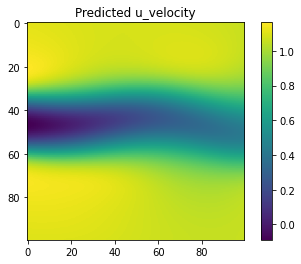

In [ ]:
uplot=np.reshape(u_pred,(100,100))
plt.imshow(uplot)
plt.title("Predicted u_velocity")
plt.colorbar()

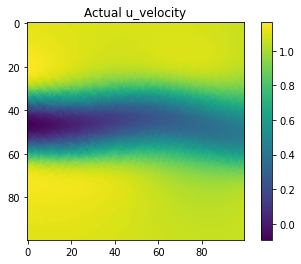

In [ ]:
upl=np.reshape(Y_star[0],(100,100))
plt.imshow(upl)
plt.title("Actual u_velocity")
plt.colorbar()

In [ ]:
def errorplot():
    eu=[]
    ev=[]
    ep=[]
    t=[]
    
    for i in range(200):
        X_star,Y_star=load_testdata(np.array([i]))
        u_pred, v_pred, p_pred = model.predict(X_star[0],X_star[1],X_star[2])
        
        # # Error
        error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
        eu.append(error_u)
        error_v = np.linalg.norm(Y_star[1] - v_pred, 2) / np.linalg.norm(Y_star[1], 2)
        ev.append(error_v)
        error_p = np.linalg.norm(Y_star[2] - p_pred, 2) / np.linalg.norm(Y_star[2], 2)
        ep.append(error_p)
      
    return eu,ev,ep 

In [ ]:
eu,ev,ep=errorplot()

In [ ]:
t=[i for i in range(200)]

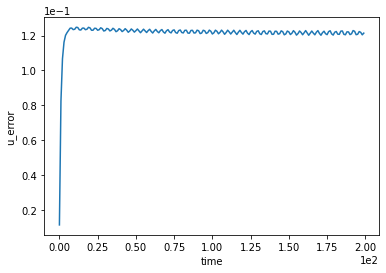

In [ ]:
plt.plot(t,eu)
plt.xlabel('time')
plt.ylabel('u_error')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

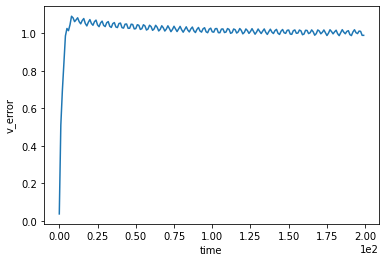

In [ ]:
plt.plot(t,ev)
plt.xlabel('time')
plt.ylabel('v_error')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

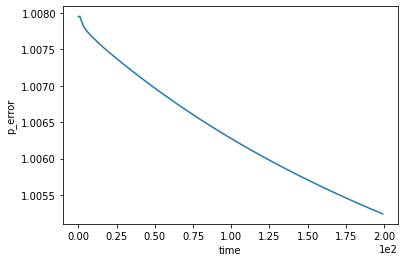

In [ ]:
plt.plot(t,ep)
plt.xlabel('time')
plt.ylabel('p_error')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [ ]:
iloss=model.loss_i
bloss=model.loss_b
rloss=model.loss_r

epochs=[i for i in range(0,110000,10)]



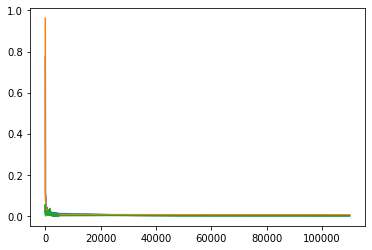

In [ ]:
plt.plot(epochs,iloss)
plt.plot(epochs,bloss)
plt.plot(epochs,rloss)